In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Display all columns`
pd.set_option('display.max_columns', None)

# Set visualization style
sns.set_style('darkgrid')

In [3]:
data = pd.read_excel(
    "Public_users.xlsx",
    header=3,
    parse_dates = [4, 5]
)
data

,User Group,Cost Center,User/Vehicle,Charging Card,Plugged in at,Unplugged at,Charging Duration,Blocking Time,Location,Charging Station,Connector,EVSE-ID,Kommentar,Price per kWh,Consumption(kWh),Net Costs,Tax Rate,Tax Costs,Gross Costs,Parking Fee Tariff,Net Parking Fee Costs,Parking Fee Tax Rate,Parking Fee Tax Costs,Gross Parking Fee Costs,Total Costs
0,Öffentliches Laden,NaN,eRoaming Nutzer,<unbekannt>,2023-09-01 16:15:42.249,2023-09-01 19:34:58.064,2h 49m 45s,3h 19m 16s,Ulanweg,ABL_10332049,Ladepunkt 2,DE*ONE*E3KHJ,NaN,0.4952,10.293,4.28,19,0.82,5.10,0,0,19,0,0,5.10
1,Öffentliches Laden,NaN,eRoaming Nutzer,<unbekannt>,2023-09-02 09:38:08.906,2023-09-02 11:05:53.221,1h 27m 26s,1h 27m 44s,Ulanweg,ABL_10332049,Ladepunkt 4,DE*ONE*EE94A,NaN,0.4952,5.035,2.10,19,0.39,2.49,0,0,19,0,0,2.49
2,Öffentliches Laden,NaN,eRoaming Nutzer,<unbekannt>,2023-09-02 11:11:07.867,2023-09-02 13:56:01.025,2h 25m 35s,2h 44m 53s,Ulanweg,ABL_10332049,Ladepunkt 4,DE*ONE*EE94A,NaN,0.4952,8.325,3.46,19,0.66,4.12,0,0,19,0,0,4.12
3,Öffentliches Laden,NaN,eRoaming Nutzer,<unbekannt>,2023-09-02 12:23:58.920,2023-09-02 13:07:01.016,0h 42m 26s,0h 43m 02s,Ulanweg,ABL_10332049,Ladepunkt 3,DE*ONE*E68JX,NaN,0.4952,7.598,3.16,19,0.60,3.76,0,0,19,0,0,3.76
4,Öffentliches Laden,NaN,eRoaming Nutzer,<unbekannt>,2023-09-03 01:00:33.374,2023-09-03 05:54:16.109,4h 39m 45s,4h 53m 43s,Ulanweg,ABL_10332049,Ladepunkt 4,DE*ONE*EE94A,NaN,0.4952,51.301,21.35,19,4.05,25.40,0,0,19,0,0,25.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Öffentliches Laden,NaN,eRoaming Nutzer,<unbekannt>,2024-01-28 12:57:50.394,2024-01-28 16:29:30.756,3h 30m 35s,3h 31m 40s,Ulanweg,ABL_10332049,Ladepunkt 4 rechts,DE*ONE*E7RVQ,NaN,0.4952,38.056,15.84,19,3.01,18.85,0,0,19,0,0,18.85
356,Öffentliches Laden,NaN,eRoaming Nutzer,<unbekannt>,2024-01-29 16:30:02.768,2024-01-29 19:47:00.651,1h 47m 06s,3h 16m 58s,Ulanweg,ABL_10332049,Ladepunkt 3 rechts,DE*ONE*E3KHJ,NaN,0.4952,11.237,4.68,19,0.88,5.56,0,0,19,0,0,5.56
357,Öffentliches Laden,NaN,eRoaming Nutzer,<unbekannt>,2024-01-30 16:21:24.355,2024-01-30 19:12:10.334,1h 22m 58s,2h 50m 46s,Ulanweg,ABL_10332049,Ladepunkt 3 rechts,DE*ONE*E3KHJ,NaN,0.4952,10.049,4.18,19,0.80,4.98,0,0,19,0,0,4.98
358,Öffentliches Laden,NaN,eRoaming Nutzer,<unbekannt>,2024-01-30 18:40:32.034,2024-01-30 22:25:16.971,3h 44m 02s,3h 44m 45s,Ulanweg,ABL_10332049,Ladepunkt 2 links,DE*ONE*EE94A,NaN,0.4952,28.906,12.03,19,2.28,14.31,0,0,19,0,0,14.31


# DATA CLEANING

In [4]:
# Create a function to rename charging stations
def rename_charge_station(df):
    if df['EVSE-ID'] == 'DE*ONE*E7RVQ' or df['EVSE-ID'] == 'DE*ONE*E3KHJ':
        charge_station = 'ABL_10332049_A'
    else:
        charge_station = 'ABL_10332049_B'
    return charge_station

In [5]:
def wrangle(dataset):
    data = pd.read_excel(
        dataset,
        header=3,
        parse_dates = [4, 5]
    )
    
    # Drop irrelevant columns
    data.drop(columns=['Kommentar', 'Cost Center', 'Charging Card', 'Parking Fee Tariff', 'Tax Rate', 'Parking Fee Tax Rate',
     'Net Parking Fee Costs', 'Parking Fee Tax Costs', 'Gross Parking Fee Costs', 'Connector'], inplace=True)

    # Rename charge station based on evse-id
    data['Charging Station'] = data.apply(rename_charge_station, axis=1)
    
    # Extract month when vehicles were plugged and unplugged
    data['Plugged_in_month'] = data['Plugged in at'].dt.month_name()
    data['Unplugged_month'] = data['Unplugged at'].dt.month_name()

    # Extract dayname when vehicles were plugged and unplugged
    data['Plugged_in_dayname'] = data['Plugged in at'].dt.day_name()
    data['Unplugged_dayname'] = data['Unplugged at'].dt.day_name()
    
    # Extract time when vehicles were plugged and unplugged
    data['Plugged_in_time'] = data['Plugged in at'].dt.time
    data['Unplugged_time'] = data['Unplugged at'].dt.time
    
    # Extract the hour of plug-in and plug-out
    data['Plugged_in_time_hour'] = data['Plugged_in_time'].astype(str).str.split(':').str[0]
    data['Unplugged_time_hour'] = data['Unplugged_time'].astype(str).str.split(':').str[0]
    
    # Convert dayname and month to categorical variables
    data['Plugged_in_month'] = pd.Categorical(
        data['Plugged_in_month'],
        categories=['September', 'October', 'November', 'December', 'January']
    )
    data['Unplugged_month'] = pd.Categorical(
        data['Unplugged_month'],
        categories=['September', 'October', 'November', 'December', 'January']
    )
    data['Plugged_in_dayname'] = pd.Categorical(
        data['Plugged_in_dayname'],
        categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    )
    data['Unplugged_dayname'] = pd.Categorical(
        data['Unplugged_dayname'],
        categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    )

    # Extracting 'Charging Duration' components
    data[['C_Hours', 'C_Minutes', 'C_Seconds']] = data['Charging Duration'].str.extract(r'(\d+)h (\d+)m (\d+)s').astype(int)
    data[['B_Hours', 'B_Minutes', 'B_Seconds']] = data['Blocking Time'].str.extract(r'(\d+)h (\d+)m (\d+)s').astype(int)

    # Convert 'Charging Duration' to total minutes as float
    data['Charging Duration'] = data['C_Hours'] + (data['C_Minutes'] / 60) + (data['C_Seconds'] / 3600)
    data['Blocking Time'] = data['B_Hours'] + (data['B_Minutes'] / 60) + (data['B_Seconds'] / 3600)
    
    # Calculate hogging time
    data['Hogging time'] = data['Blocking Time']- data['Charging Duration']

    # Drop intermediate columns
    data.drop(['C_Hours', 'B_Hours', 'C_Minutes', 'B_Minutes', 'C_Seconds', 'B_Seconds'], axis=1, inplace=True)

    return data

In [6]:
# New
user_data = wrangle("Public_users.xlsx")
user_data.head()

,User Group,User/Vehicle,Plugged in at,Unplugged at,Charging Duration,Blocking Time,Location,Charging Station,EVSE-ID,Price per kWh,Consumption(kWh),Net Costs,Tax Costs,Gross Costs,Total Costs,Plugged_in_month,Unplugged_month,Plugged_in_dayname,Unplugged_dayname,Plugged_in_time,Unplugged_time,Plugged_in_time_hour,Unplugged_time_hour,Hogging time
0,Öffentliches Laden,eRoaming Nutzer,2023-09-01 16:15:42.249,2023-09-01 19:34:58.064,2.829167,3.321111,Ulanweg,ABL_10332049_A,DE*ONE*E3KHJ,0.4952,10.293,4.28,0.82,5.10,5.10,September,September,Friday,Friday,16:15:42.249000,19:34:58.064000,16,19,0.491944
1,Öffentliches Laden,eRoaming Nutzer,2023-09-02 09:38:08.906,2023-09-02 11:05:53.221,1.457222,1.462222,Ulanweg,ABL_10332049_B,DE*ONE*EE94A,0.4952,5.035,2.10,0.39,2.49,2.49,September,September,Saturday,Saturday,09:38:08.906000,11:05:53.221000,09,11,0.005000
2,Öffentliches Laden,eRoaming Nutzer,2023-09-02 11:11:07.867,2023-09-02 13:56:01.025,2.426389,2.748056,Ulanweg,ABL_10332049_B,DE*ONE*EE94A,0.4952,8.325,3.46,0.66,4.12,4.12,September,September,Saturday,Saturday,11:11:07.867000,13:56:01.025000,11,13,0.321667
3,Öffentliches Laden,eRoaming Nutzer,2023-09-02 12:23:58.920,2023-09-02 13:07:01.016,0.707222,0.717222,Ulanweg,ABL_10332049_B,DE*ONE*E68JX,0.4952,7.598,3.16,0.60,3.76,3.76,September,September,Saturday,Saturday,12:23:58.920000,13:07:01.016000,12,13,0.010000
4,Öffentliches Laden,eRoaming Nutzer,2023-09-03 01:00:33.374,2023-09-03 05:54:16.109,4.662500,4.895278,Ulanweg,ABL_10332049_B,DE*ONE*EE94A,0.4952,51.301,21.35,4.05,25.40,25.40,September,September,Sunday,Sunday,01:00:33.374000,05:54:16.109000,01,05,0.232778


In [7]:
user_data.pivot_table(index='Plugged_in_dayname', values=['Charging Duration','Tax Costs','Gross Costs'])

,Charging Duration,Gross Costs,Tax Costs
Plugged_in_dayname,,,
Sunday,2.846868,11.744500,1.875750
Monday,2.651074,10.857838,1.734324
Tuesday,2.398340,9.600513,1.532051
Wednesday,2.501137,10.347188,1.653125
Thursday,2.422396,9.922500,1.583750
Friday,1.924122,7.112857,1.135357
Saturday,2.444638,9.675978,1.544348


## Hourly Variation 

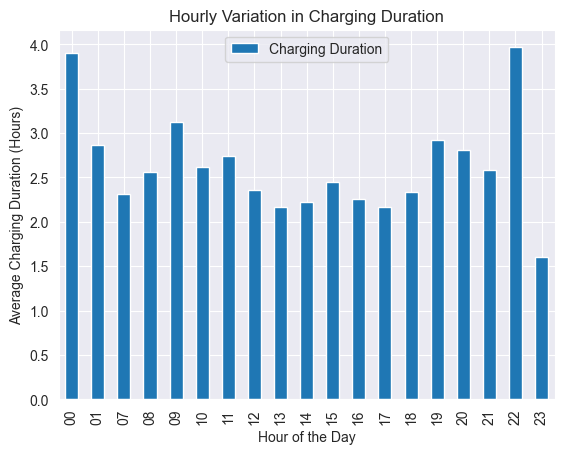

In [8]:
user_data.pivot_table(index='Plugged_in_time_hour', values='Charging Duration').plot(kind='bar')
plt.title('Hourly Variation in Charging Duration')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Charging Duration (Hours)')
plt.show()

## Peak charging hour:

In [9]:
peak_charging_hour = user_data.pivot_table(index='Unplugged_time_hour', values='Charging Duration', aggfunc='sum')
print(f"Peak charging hour: {peak_charging_hour.idxmax()[0]}")

Peak charging hour: 20


## Off peak charging hour

In [10]:
off_peak_charging_hour = user_data.pivot_table(index='Unplugged_time_hour', values='Charging Duration', aggfunc='sum')
print(f"Off peak charging hour: {off_peak_charging_hour.idxmin()[0]}")

Off peak charging hour: 01


## Peak charging day

In [11]:
peak_charging_day = user_data.pivot_table(index='Unplugged_dayname', values='Charging Duration', aggfunc='sum')
print(f"Peak charging day: {peak_charging_day.idxmax()[0]}")

Peak charging day: Sunday


## Least charging day

In [12]:
least_charging_day = user_data.pivot_table(index='Unplugged_dayname', values='Charging Duration', aggfunc='sum')
print(f"Least charging day: {peak_charging_day.idxmin()[0]}")

Least charging day: Monday


## Peak charging month

In [13]:
peak_charging_month = user_data.pivot_table(index='Unplugged_month', values='Charging Duration', aggfunc='sum')
print(f"Peak charging month: {peak_charging_month.idxmax()[0]}")

Peak charging month: January


## Least charging month

In [14]:
least_charging_month = user_data.pivot_table(index='Unplugged_month', values='Charging Duration', aggfunc='sum')
print(f"Least charging month: {least_charging_month.idxmin()[0]}")

Least charging month: September


## Peak consumption hour

In [15]:
peak_consumption_hour = user_data.pivot_table(index='Unplugged_time_hour', values='Consumption(kWh)', aggfunc='sum')
print(f"Peak consumption hour: {peak_consumption_hour.idxmax()[0]}")

Peak consumption hour: 20


## Off peak consumption hour

In [16]:
off_peak_consumption_hour = user_data.pivot_table(index='Unplugged_time_hour', values='Consumption(kWh)', aggfunc='sum')
print(f"Off peak consumption hour: {off_peak_consumption_hour.idxmin()[0]}")

Off peak consumption hour: 01


## Peak consumption day

In [17]:
peak_consumption_day = user_data.pivot_table(index='Unplugged_dayname', values='Consumption(kWh)', aggfunc='sum')
print(f"Peak consumption day: {peak_consumption_day.idxmax()[0]}")

Peak consumption day: Sunday


## Least consumption day

In [18]:
least_consumption_day = user_data.pivot_table(index='Unplugged_dayname', values='Consumption(kWh)', aggfunc='sum')
print(f"Least consumption day: {least_consumption_day.idxmin()[0]}")

Least consumption day: Monday


## Peak consumption month

In [19]:
peak_consumption_month = user_data.pivot_table(index='Unplugged_month', values='Consumption(kWh)', aggfunc='sum')
print(f"Peak consumption month: {peak_consumption_month.idxmax()[0]}")

Peak consumption month: January


## Least consumption month

In [20]:
least_consumption_month = user_data.pivot_table(index='Unplugged_month', values='Consumption(kWh)', aggfunc='sum')
print(f"Least consumption month: {least_consumption_month.idxmin()[0]}")

Least consumption month: September


# EXPLORATORY DATA ANALYSIS

In [21]:
# Extract daytime data
user_data_daytime = user_data.set_index('Plugged in at').between_time('6:00', '18:00').reset_index()
# Extract nighttime data
user_data_nighttime = user_data.set_index('Plugged in at').between_time('18:01', '5:59').reset_index()

In [22]:
# Split into each month
user_data_september = user_data[user_data['Plugged_in_month'] == 'September']
user_data_october = user_data[user_data['Plugged_in_month'] == 'October']
user_data_november = user_data[user_data['Plugged_in_month'] == 'November']
user_data_december = user_data[user_data['Plugged_in_month'] == 'December']
user_data_january = user_data[user_data['Plugged_in_month'] == 'January']

### Distribution of Connection time

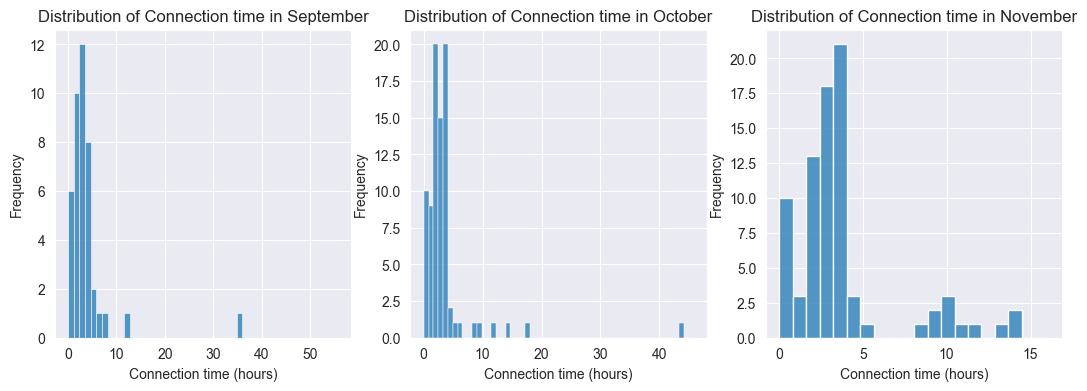

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_september,
    x='Blocking Time',
    ax=ax[0],
    binrange=(user_data_september['Blocking Time'].min(), user_data_september['Blocking Time'].max() + 20)
)
ax[0].set_title('Distribution of Connection time in September')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# October
sns.histplot(
    data=user_data_october,
    x='Blocking Time',
    ax=ax[1],
    binrange=(user_data_october['Blocking Time'].min(), user_data_october['Blocking Time'].max() + 2)
)
ax[1].set_title('Distribution of Connection time in October')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# November
sns.histplot(
    data=user_data_november,
    x='Blocking Time',
    ax=ax[2],
    binrange=(user_data_november['Blocking Time'].min(), user_data_november['Blocking Time'].max() + 2)
)
ax[2].set_title('Distribution of Connection time in November')
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Connection time (hours)')

# Save figure
plt.savefig('P_images/connection-time-distribution-1', bbox_inches='tight')
plt.show()

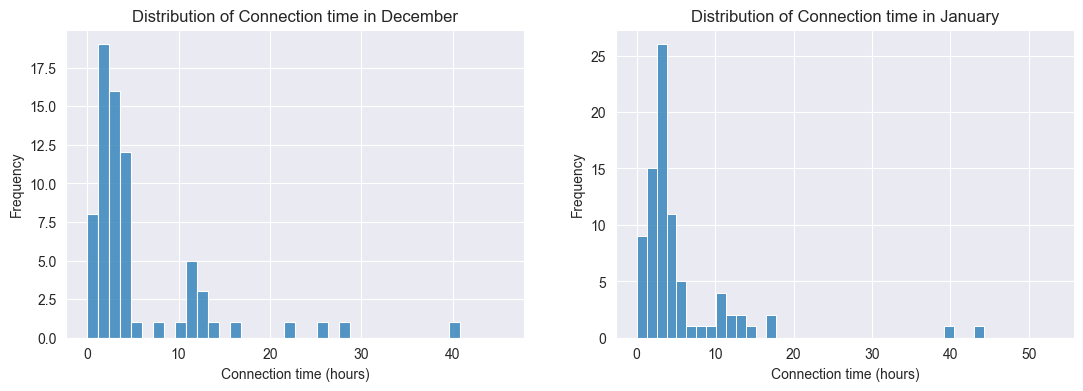

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=user_data_december,
    x='Blocking Time',
    ax=ax[0],
    binrange=(user_data_december['Blocking Time'].min(), user_data_december['Blocking Time'].max() + 5)
)
ax[0].set_title('Distribution of Connection time in December')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# January
sns.histplot(
    data=user_data_january,
    x='Blocking Time',
    ax=ax[1],
    binrange=(user_data_january['Blocking Time'].min(), user_data_january['Blocking Time'].max() + 10)
)
ax[1].set_title('Distribution of Connection time in January')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# Save figure
plt.savefig('P_images/connection-time-distribution-2', bbox_inches='tight')
plt.show()

### Correct outliers

In [25]:
user_data_cc = user_data.copy()

In [26]:
# Extract daytime data
user_data_cc_daytime = user_data_cc.set_index('Plugged in at').between_time('6:00', '18:00').reset_index()
# Extract nighttime data
user_data_cc_nighttime = user_data_cc.set_index('Plugged in at').between_time('18:01', '5:59').reset_index()

In [27]:
# Split into each month
user_data_cc_september = user_data_cc[user_data_cc['Plugged_in_month'] == 'September']
user_data_cc_october = user_data_cc[user_data_cc['Plugged_in_month'] == 'October']
user_data_cc_november = user_data_cc[user_data_cc['Plugged_in_month'] == 'November']
user_data_cc_december = user_data_cc[user_data_cc['Plugged_in_month'] == 'December']
user_data_cc_january = user_data_cc[user_data_cc['Plugged_in_month'] == 'January']

These are values whose connection time do not seem to match the consumption

#### September

In [28]:
user_data_cc_september[user_data_cc_september['Blocking Time'] > 20]

,User Group,User/Vehicle,Plugged in at,Unplugged at,Charging Duration,Blocking Time,Location,Charging Station,EVSE-ID,Price per kWh,Consumption(kWh),Net Costs,Tax Costs,Gross Costs,Total Costs,Plugged_in_month,Unplugged_month,Plugged_in_dayname,Unplugged_dayname,Plugged_in_time,Unplugged_time,Plugged_in_time_hour,Unplugged_time_hour,Hogging time
6,Öffentliches Laden,eRoaming Nutzer,2023-09-04 19:44:28.584,2023-09-06 07:22:07.401,6.201944,35.6275,Ulanweg,ABL_10332049_B,DE*ONE*EE94A,0.4952,67.342,28.02,5.33,33.35,33.35,September,September,Monday,Wednesday,19:44:28.584000,07:22:07.401000,19,07,29.425556


In [29]:
user_data_cc_september.drop([6], inplace=True)

Consumption cannot be used to obtain Blocking Time since both are high. It also had the highest charge time for a session in september. The row is dropped since the Blocking Time cannot be aggregated by any means.

#### October

In [30]:
user_data_cc_october[user_data_cc_october['Blocking Time'] > 40]

,User Group,User/Vehicle,Plugged in at,Unplugged at,Charging Duration,Blocking Time,Location,Charging Station,EVSE-ID,Price per kWh,Consumption(kWh),Net Costs,Tax Costs,Gross Costs,Total Costs,Plugged_in_month,Unplugged_month,Plugged_in_dayname,Unplugged_dayname,Plugged_in_time,Unplugged_time,Plugged_in_time_hour,Unplugged_time_hour,Hogging time
107,Öffentliches Laden,eRoaming Nutzer,2023-10-23 19:03:09.684,2023-10-25 14:47:55.773,4.885833,43.746111,Ulanweg,ABL_10332049_A,DE*ONE*E7RVQ,0.4952,49.837,20.74,3.94,24.68,24.68,October,October,Monday,Wednesday,19:03:09.684000,14:47:55.773000,19,14,38.860278


In [31]:
# Obtain the mean blocking/connection time for sessions with similar consumption
mean_blocking_time = user_data_cc_october.drop([107])[(user_data_cc_october['Consumption(kWh)'] >= 40) & (user_data_cc_october['Consumption(kWh)'] <= 50)]['Blocking Time'].mean()

# Assign the mean Blocking Time to the outlier
user_data_cc_october.loc[107, 'Blocking Time'] = mean_blocking_time

#### December

In [32]:
user_data_cc_december[user_data_cc_december['Blocking Time'] > 40]

,User Group,User/Vehicle,Plugged in at,Unplugged at,Charging Duration,Blocking Time,Location,Charging Station,EVSE-ID,Price per kWh,Consumption(kWh),Net Costs,Tax Costs,Gross Costs,Total Costs,Plugged_in_month,Unplugged_month,Plugged_in_dayname,Unplugged_dayname,Plugged_in_time,Unplugged_time,Plugged_in_time_hour,Unplugged_time_hour,Hogging time
210,Öffentliches Laden,eRoaming Nutzer,2023-12-02 14:39:35.278,2023-12-04 07:13:11.382,4.045,40.56,Ulanweg,ABL_10332049_A,DE*ONE*E7RVQ,0.4952,43.12,17.94,3.41,21.35,21.35,December,December,Saturday,Monday,14:39:35.278000,07:13:11.382000,14,07,36.515


In [33]:
# Obtain the mean Blocking Time for sessions with similar consumption values
mean_blocking_time = user_data_cc_december.drop([210])[(user_data_cc_december['Consumption(kWh)'] >= 40) & (user_data_cc_december['Consumption(kWh)'] <= 50)]['Blocking Time'].mean()

# Assign the mean Blocking Time to the outlier
user_data_cc_december.loc[210, 'Blocking Time'] = mean_blocking_time

#### January

In [34]:
user_data_cc_january[user_data_cc_january['Blocking Time'] > 35]

,User Group,User/Vehicle,Plugged in at,Unplugged at,Charging Duration,Blocking Time,Location,Charging Station,EVSE-ID,Price per kWh,Consumption(kWh),Net Costs,Tax Costs,Gross Costs,Total Costs,Plugged_in_month,Unplugged_month,Plugged_in_dayname,Unplugged_dayname,Plugged_in_time,Unplugged_time,Plugged_in_time_hour,Unplugged_time_hour,Hogging time
278,Öffentliches Laden,eRoaming Nutzer,2024-01-01 16:03:27.195,2024-01-03 08:08:13.963,6.216389,40.079722,Ulanweg,ABL_10332049_B,DE*ONE*EE94A,0.4952,59.239,24.65,4.69,29.34,29.34,January,January,Monday,Wednesday,16:03:27.195000,08:08:13.963000,16,08,33.863333
294,Öffentliches Laden,eRoaming Nutzer,2024-01-07 19:35:14.469,2024-01-09 14:40:15.123,7.441389,43.083611,Ulanweg,ABL_10332049_A,DE*ONE*E7RVQ,0.4952,75.688,31.50,5.98,37.48,37.48,January,January,Sunday,Tuesday,19:35:14.469000,14:40:15.123000,19,14,35.642222


In [35]:
mean_blocking_time = user_data_cc_january.drop([278])[(user_data_cc_january['Consumption(kWh)'] >= 50) & (user_data_cc_january['Consumption(kWh)'] <= 65)]['Blocking Time'].mean()

user_data_cc_january.loc[278, 'Blocking Time'] = mean_blocking_time

In [36]:
mean_blocking_time = user_data_cc_january.drop([294])[(user_data_cc_january['Consumption(kWh)'] >= 70) & (user_data_cc_january['Consumption(kWh)'] <= 80)]['Blocking Time'].mean()

user_data_cc_january.loc[294, 'Blocking Time'] = mean_blocking_time

Redo the plots without outliers

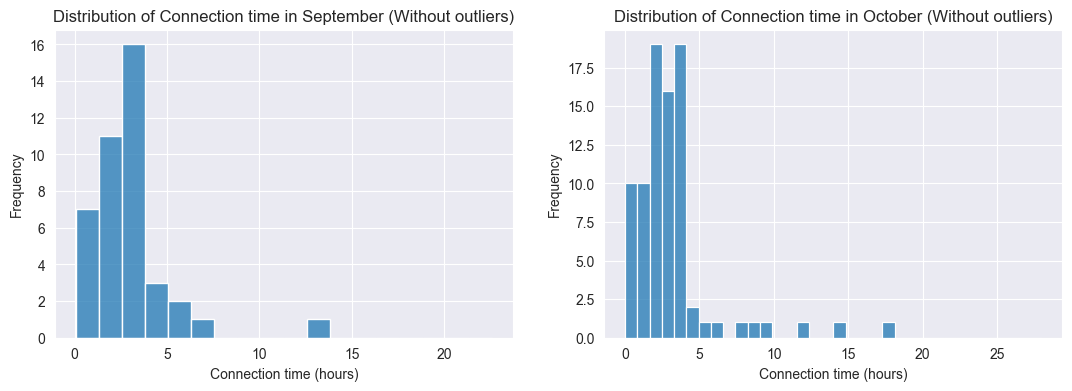

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_cc_september,
    x='Blocking Time',
    ax=ax[0],
    binrange=(user_data_cc_september['Blocking Time'].min(), user_data_cc_september['Blocking Time'].max() + 10)
)
ax[0].set_title('Distribution of Connection time in September (Without outliers)')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# October
sns.histplot(
    data=user_data_cc_october,
    x='Blocking Time',
    ax=ax[1],
    binrange=(user_data_cc_october['Blocking Time'].min(), user_data_cc_october['Blocking Time'].max() + 10)
)
ax[1].set_title('Distribution of Connection time in October (Without outliers)')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# Save figure
plt.savefig('P_images/connection-time-distribution-1-without-outlier', bbox_inches='tight')
plt.show()

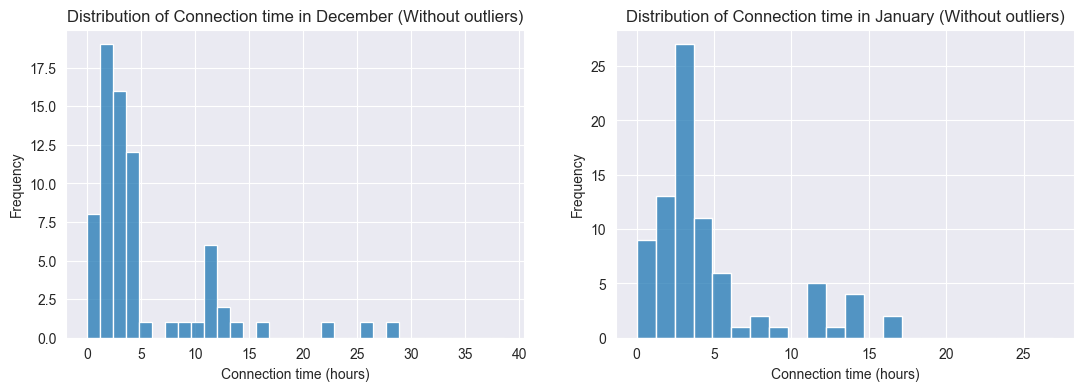

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=user_data_cc_december,
    x='Blocking Time',
    ax=ax[0],
    binrange=(user_data_cc_december['Blocking Time'].min(), user_data_cc_december['Blocking Time'].max() + 10)
)
ax[0].set_title('Distribution of Connection time in December (Without outliers)')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# January
sns.histplot(
    data=user_data_cc_january,
    x='Blocking Time',
    ax=ax[1],
    binrange=(user_data_cc_january['Blocking Time'].min(), user_data_cc_january['Blocking Time'].max() + 10)
)
ax[1].set_title('Distribution of Connection time in January (Without outliers)')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# Save figure
plt.savefig('P_images/connection-time-distribution-2-without-outlier', bbox_inches='tight')
plt.show()

### Connection time (monthly)

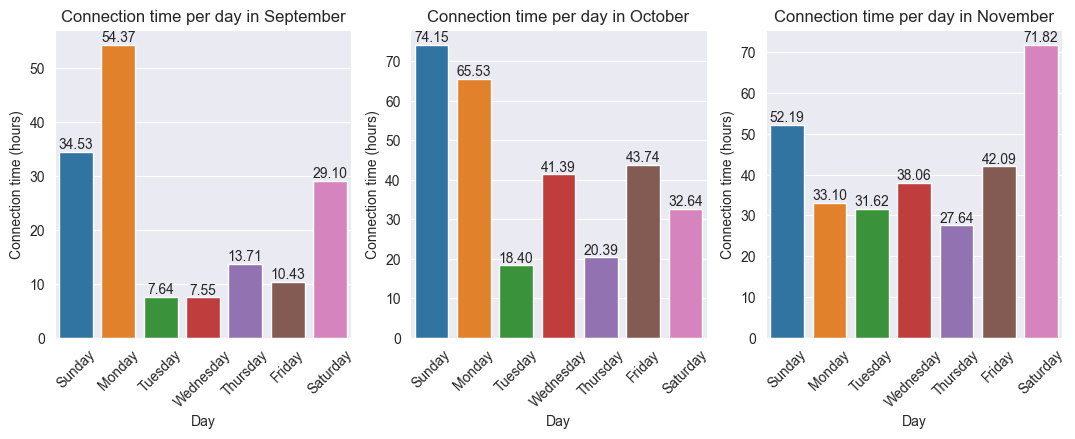

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.barplot(
    data=user_data_september.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Connection time per day in September')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# October
sns.barplot(
    data=user_data_october.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Connection time per day in October')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# November
sns.barplot(
    data=user_data_november.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[2]
)
ax[2].tick_params(axis='x', rotation=45)
ax[2].set_title('Connection time per day in November')
ax[2].set_ylabel('Connection time (hours)')
ax[2].set_xlabel('Day')
ax[2].bar_label(ax[2].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('P_images/connection-time-per-day-1', bbox_inches='tight')
plt.show()

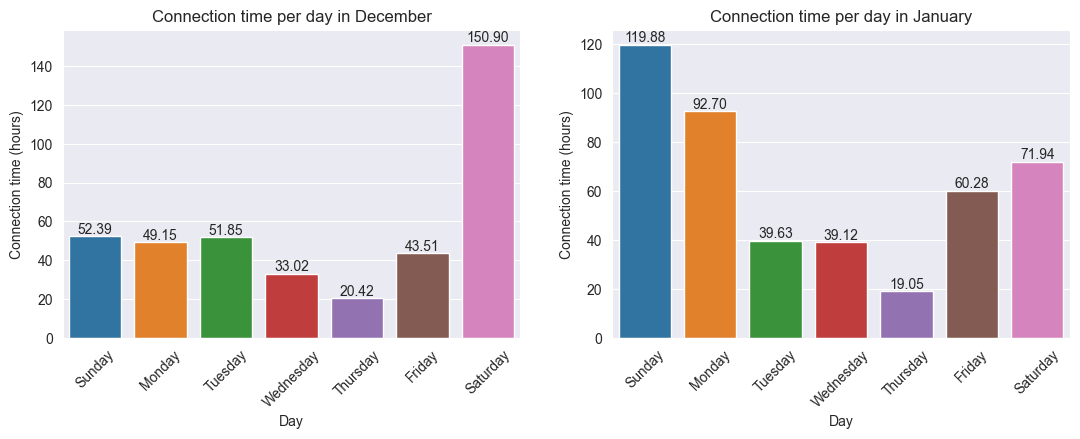

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.barplot(
    data=user_data_december.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Connection time per day in December')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# January
sns.barplot(
    data=user_data_january.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Connection time per day in January')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('P_images/connection-time-per-day-2', bbox_inches='tight')
plt.show()

#### Without outliers

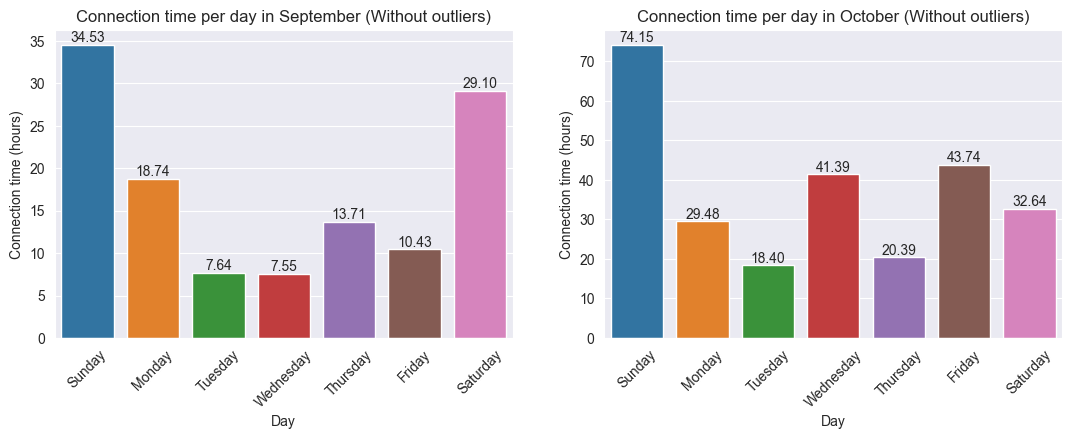

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.barplot(
    data=user_data_cc_september.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Connection time per day in September (Without outliers)')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# October
sns.barplot(
    data=user_data_cc_october.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Connection time per day in October (Without outliers)')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('P_images/connection-time-per-day-1-without-outlier', bbox_inches='tight')
plt.show()

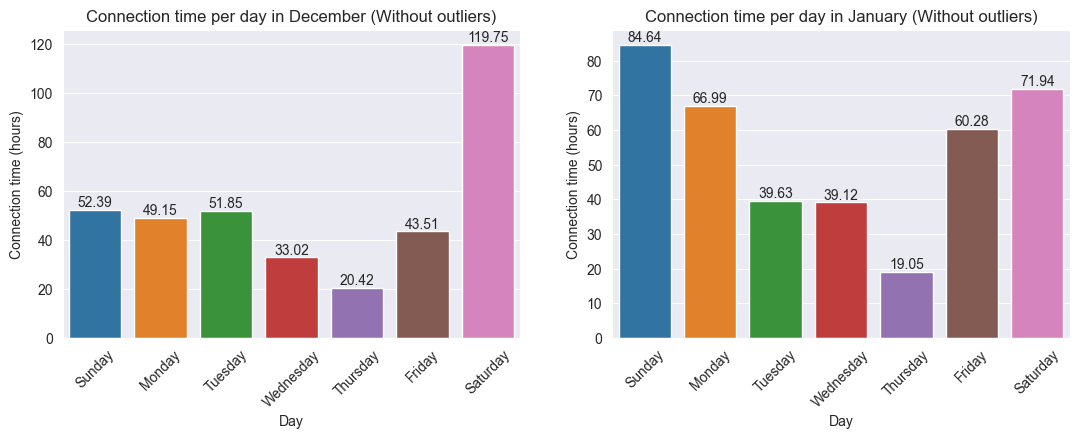

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.barplot(
    data=user_data_cc_december.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Connection time per day in December (Without outliers)')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# January
sns.barplot(
    data=user_data_cc_january.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Connection time per day in January (Without outliers)')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('P_images/connection-time-per-day-2-without-outliers', bbox_inches='tight')
plt.show()

### Distribution of Charge time

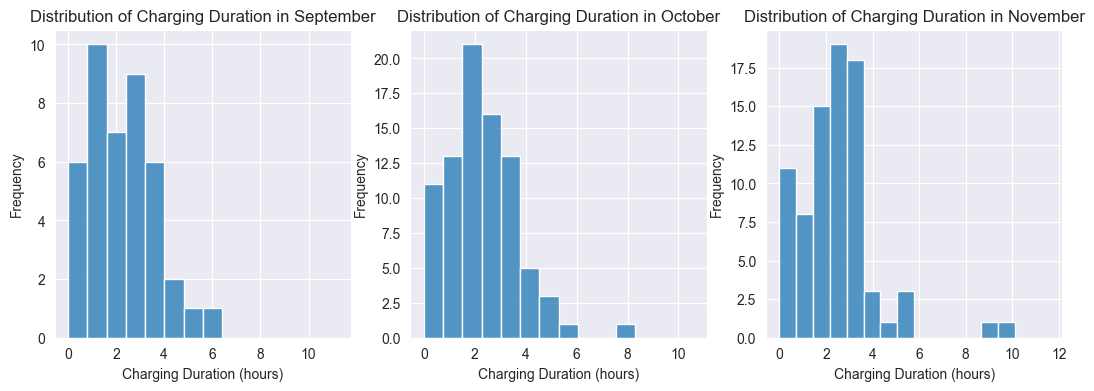

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_september,
    x='Charging Duration',
    ax=ax[0],
    binrange=(user_data_september['Charging Duration'].min(), user_data_september['Charging Duration'].max() + 5)
)
ax[0].set_title('Distribution of Charging Duration in September')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Charging Duration (hours)')

# October
sns.histplot(
    data=user_data_october,
    x='Charging Duration',
    ax=ax[1],
    binrange=(user_data_october['Charging Duration'].min(), user_data_october['Charging Duration'].max() + 3)
)
ax[1].set_title('Distribution of Charging Duration in October')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Charging Duration (hours)')

# November
sns.histplot(
    data=user_data_november,
    x='Charging Duration',
    ax=ax[2],
    binrange=(user_data_november['Charging Duration'].min(), user_data_november['Charging Duration'].max() + 2)
)
ax[2].set_title('Distribution of Charging Duration in November')
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Charging Duration (hours)')

# Save figure
plt.savefig('P_images/charge-time-distribution-1', bbox_inches='tight')
plt.show()

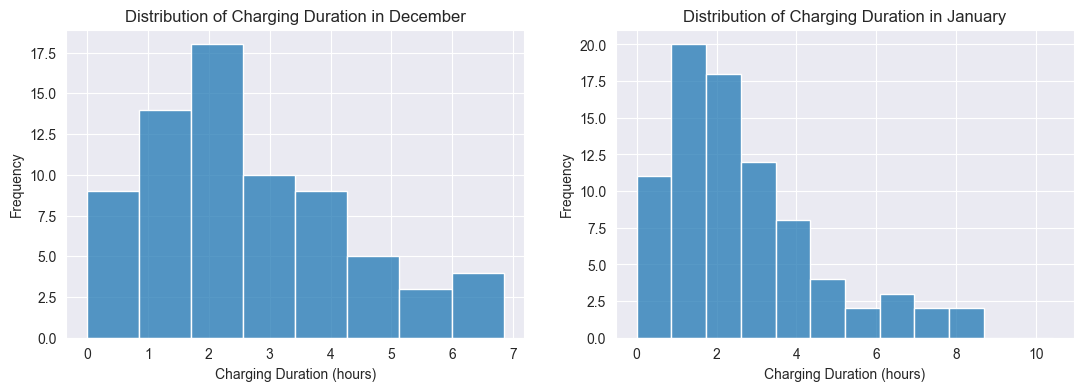

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=user_data_december,
    x='Charging Duration',
    ax=ax[0]
)
ax[0].set_title('Distribution of Charging Duration in December')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Charging Duration (hours)')

# January
sns.histplot(
    data=user_data_january,
    x='Charging Duration',
    ax=ax[1],
    binrange=(user_data_january['Charging Duration'].min(), user_data_january['Charging Duration'].max() + 2)
)
ax[1].set_title('Distribution of Charging Duration in January')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Charging Duration (hours)')

# Save figure
plt.savefig('P_images/charge-time-distribution-2', bbox_inches='tight')
plt.show()

### Distribution of Consumption

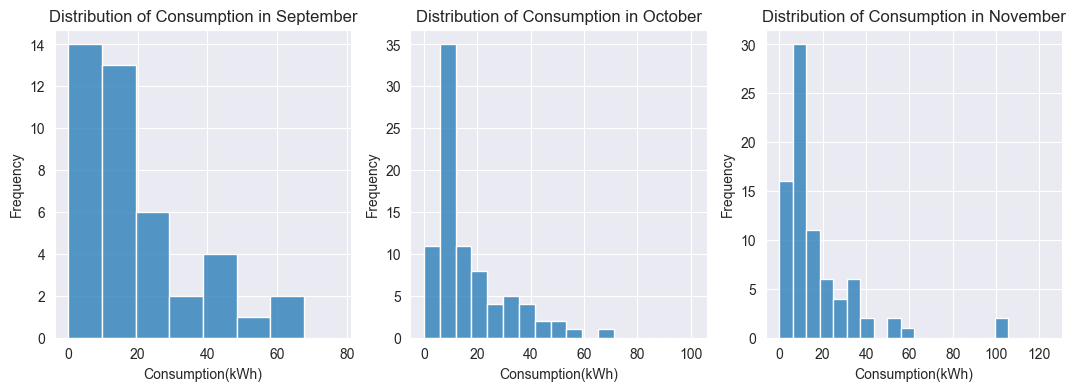

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_september,
    x='Consumption(kWh)',
    ax=ax[0],
    binrange=(user_data_september['Consumption(kWh)'].min(), user_data_september['Consumption(kWh)'].max() + 10)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Consumption(kWh)')
ax[0].set_title('Distribution of Consumption in September')

# October
sns.histplot(
    data=user_data_october,
    x='Consumption(kWh)',
    ax=ax[1],
    binrange=(user_data_october['Consumption(kWh)'].min(), user_data_october['Consumption(kWh)'].max() + 30)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Consumption(kWh)')
ax[1].set_title('Distribution of Consumption in October')

# November
sns.histplot(
    data=user_data_november,
    x='Consumption(kWh)',
    ax=ax[2],
    binrange=(user_data_november['Consumption(kWh)'].min(), user_data_november['Consumption(kWh)'].max() + 20)
)
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Consumption(kWh)')
ax[2].set_title('Distribution of Consumption in November')

# Save figure
plt.savefig('P_images/consumption-distribution-1', bbox_inches='tight')
plt.show()

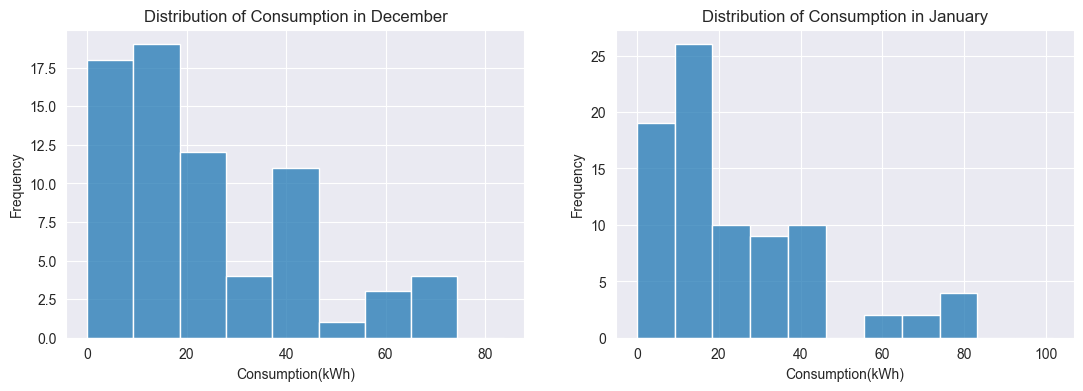

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=user_data_december,
    x='Consumption(kWh)',
    ax=ax[0],
    binrange=(user_data_december['Consumption(kWh)'].min(), user_data_december['Consumption(kWh)'].max() + 10)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Consumption(kWh)')
ax[0].set_title('Distribution of Consumption in December')

# January
sns.histplot(
    data=user_data_january,
    x='Consumption(kWh)',
    ax=ax[1],
    binrange=(user_data_january['Consumption(kWh)'].min(), user_data_january['Consumption(kWh)'].max() + 20)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Consumption(kWh)')
ax[1].set_title('Distribution of Consumption in January')

# Save figure
plt.savefig('P_images/consumption-distribution-2', bbox_inches='tight')
plt.show()

### Correct outliers

#### November

In [47]:
user_data_cc_november[user_data_cc_november['Consumption(kWh)'] > 100]

,User Group,User/Vehicle,Plugged in at,Unplugged at,Charging Duration,Blocking Time,Location,Charging Station,EVSE-ID,Price per kWh,Consumption(kWh),Net Costs,Tax Costs,Gross Costs,Total Costs,Plugged_in_month,Unplugged_month,Plugged_in_dayname,Unplugged_dayname,Plugged_in_time,Unplugged_time,Plugged_in_time_hour,Unplugged_time_hour,Hogging time
166,Öffentliches Laden,eRoaming Nutzer,2023-11-13 19:18:42.059,2023-11-14 06:45:36.462,9.570556,11.448333,Ulanweg,ABL_10332049_B,DE*ONE*EE94A,0.4952,104.36,43.43,8.25,51.68,51.68,November,November,Monday,Tuesday,19:18:42.059000,06:45:36.462000,19,06,1.877778


In [48]:
mean_consumption = user_data_cc_november[(user_data_cc_november['Blocking Time'] >= 9) & (user_data_cc_november['Blocking Time'] <= 12)]['Consumption(kWh)'].mean()

user_data_cc_november.loc[166, 'Consumption(kWh)'] = mean_consumption

In [49]:
user_data_cc_november[user_data_cc_november['Consumption(kWh)'] >= 80]

,User Group,User/Vehicle,Plugged in at,Unplugged at,Charging Duration,Blocking Time,Location,Charging Station,EVSE-ID,Price per kWh,Consumption(kWh),Net Costs,Tax Costs,Gross Costs,Total Costs,Plugged_in_month,Unplugged_month,Plugged_in_dayname,Unplugged_dayname,Plugged_in_time,Unplugged_time,Plugged_in_time_hour,Unplugged_time_hour,Hogging time
176,Öffentliches Laden,eRoaming Nutzer,2023-11-19 11:36:11.680,2023-11-19 20:45:09.629,9.136944,9.149444,Ulanweg,ABL_10332049_A,DE*ONE*E7RVQ,0.4952,99.645,41.47,7.87,49.34,49.34,November,November,Sunday,Sunday,11:36:11.680000,20:45:09.629000,11,20,0.0125


In [50]:
mean_consumption = user_data_cc_november[(user_data_cc_november['Blocking Time'] >= 9) & (user_data_cc_november['Blocking Time'] <= 10)]['Consumption(kWh)'].mean()

user_data_cc_november.loc[176, 'Consumption(kWh)'] = mean_consumption

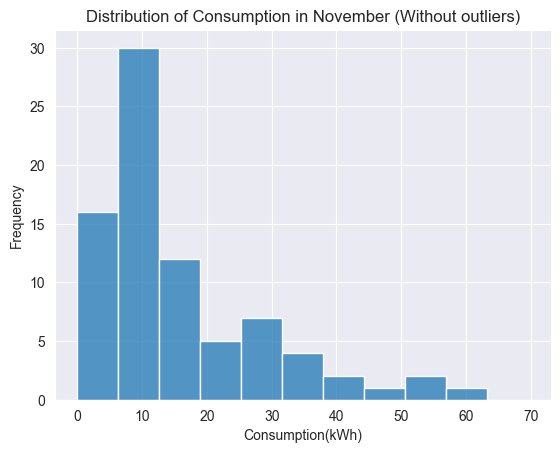

In [51]:
# November
sns.histplot(
    data=user_data_cc_november,
    x='Consumption(kWh)',
    binrange=(user_data_cc_november['Consumption(kWh)'].min(), user_data_cc_november['Consumption(kWh)'].max() + 10)
)
plt.ylabel('Frequency')
plt.xlabel('Consumption(kWh)')
plt.title('Distribution of Consumption in November (Without outliers)')

# Save figure
plt.savefig('P_images/consumption-distribution-1-without-outlier', bbox_inches='tight')
plt.show()

### Consumption (monthly)

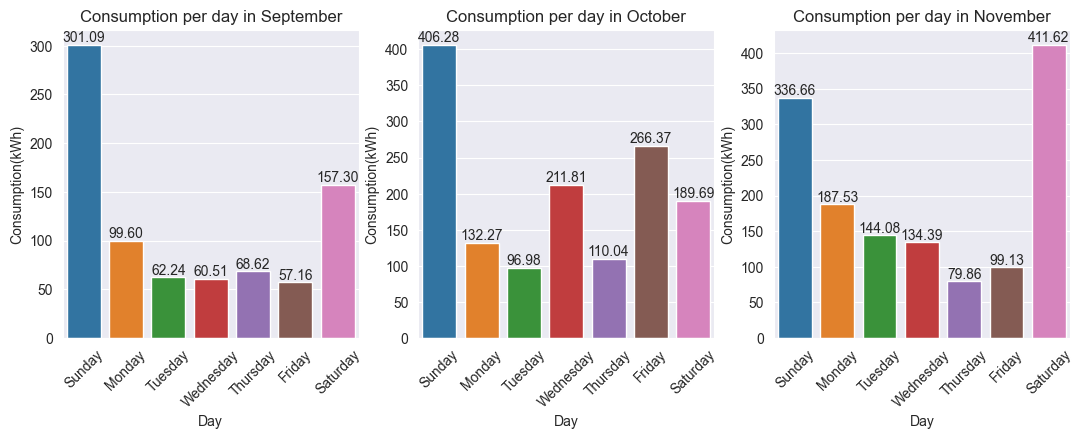

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.barplot(
    data=user_data_september.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Consumption per day in September')
ax[0].set_ylabel('Consumption(kWh)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# October
sns.barplot(
    data=user_data_october.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Consumption per day in October')
ax[1].set_ylabel('Consumption(kWh)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# November
sns.barplot(
    data=user_data_november.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[2]
)
ax[2].set_title('Consumption per day in November')
ax[2].set_ylabel('Consumption(kWh)')
ax[2].set_xlabel('Day')
ax[2].tick_params(axis='x', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('P_images/consumption-per-day-1', bbox_inches='tight')
plt.show()

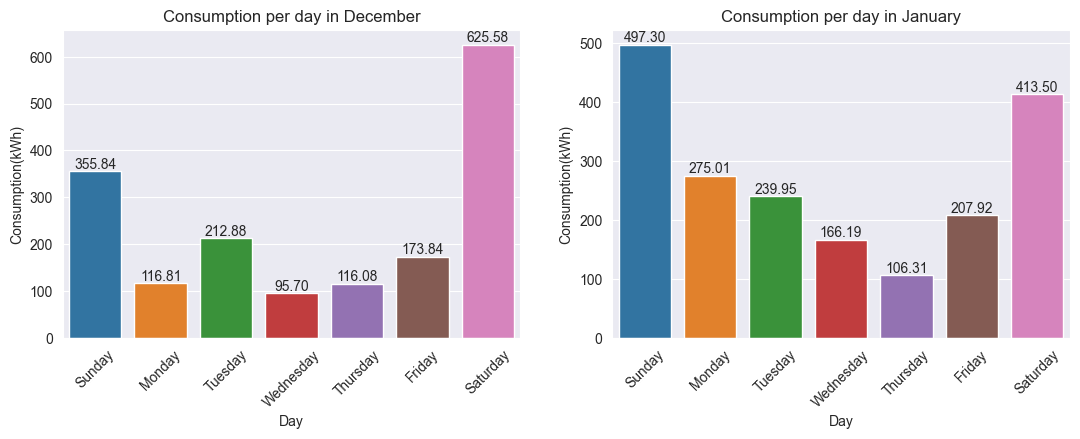

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.barplot(
    data=user_data_december.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Consumption per day in December')
ax[0].set_ylabel('Consumption(kWh)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# January
sns.barplot(
    data=user_data_january.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Consumption per day in January')
ax[1].set_ylabel('Consumption(kWh)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('P_images/consumption-per-day-2', bbox_inches='tight')
plt.show()

#### Without outlier

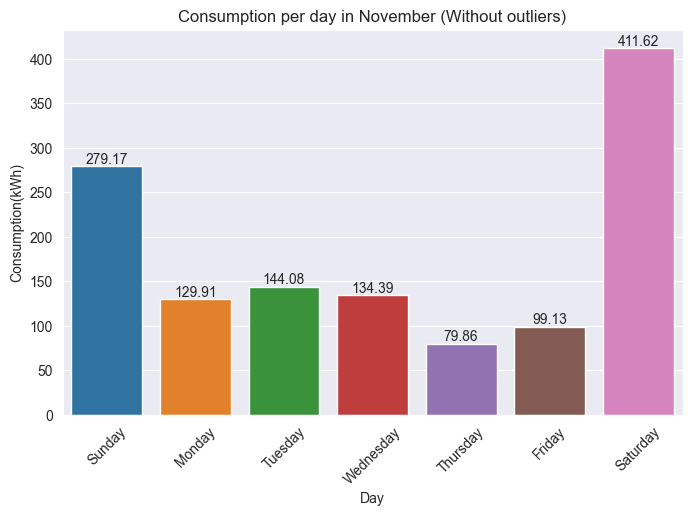

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

# November
sns.barplot(
    data=user_data_cc_november.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax
)
ax.set_title('Consumption per day in November (Without outliers)')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Day')
ax.tick_params(axis='x', rotation=45)
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('P_images/consumption-per-day-1-without-outliers', bbox_inches='tight')
plt.show()

### Distribution of Hogging time

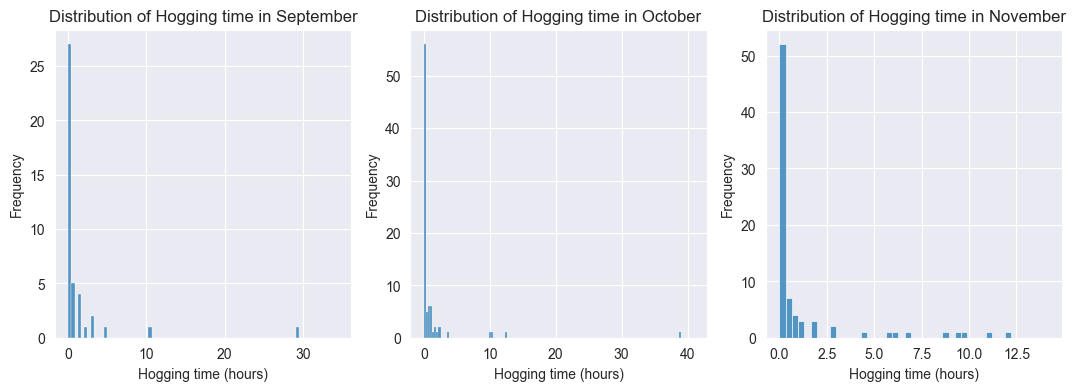

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_september,
    x='Hogging time',
    ax=ax[0],
    binrange=(user_data_september['Hogging time'].min(), user_data_september['Hogging time'].max() + 5)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in September')

# October
sns.histplot(
    data=user_data_october,
    x='Hogging time',
    ax=ax[1],
    binrange=(user_data_october['Hogging time'].min(), user_data_october['Hogging time'].max() + 2)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in October')

# November
sns.histplot(
    data=user_data_november,
    x='Hogging time',
    ax=ax[2],
    binrange=(user_data_november['Hogging time'].min(), user_data_november['Hogging time'].max() + 2)
)
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Hogging time (hours)')
ax[2].set_title('Distribution of Hogging time in November')

# Save figure
plt.savefig('P_images/hogging-time-distribution-1', bbox_inches='tight')
plt.show()

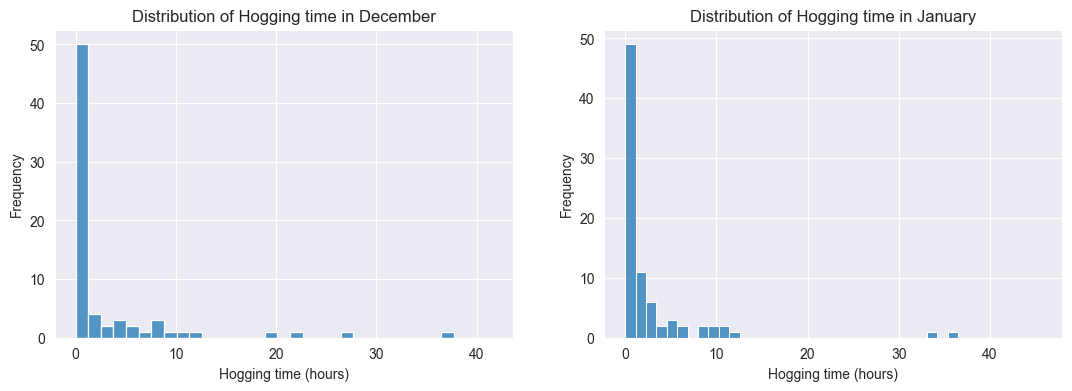

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_december,
    x='Hogging time',
    ax=ax[0],
    binrange=(user_data_december['Hogging time'].min(), user_data_december['Hogging time'].max() + 5)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in December')

# October
sns.histplot(
    data=user_data_january,
    x='Hogging time',
    ax=ax[1],
    binrange=(user_data_january['Hogging time'].min(), user_data_january['Hogging time'].max() + 10)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in January')

# Save figure
plt.savefig('P_images/hogging-time-distribution-2', bbox_inches='tight')
plt.show()

#### Hogging time percentage per month

In [60]:
# Obtain total hogging time per month
user_data_hogging_month = user_data.groupby('Plugged_in_month')['Hogging time'].sum().reset_index()

In [61]:
# Calculate the percentage hogging time per month
user_data_hogging_month['Percentage'] = (user_data_hogging_month['Hogging time'] / user_data_hogging_month['Hogging time'].sum()) * 100

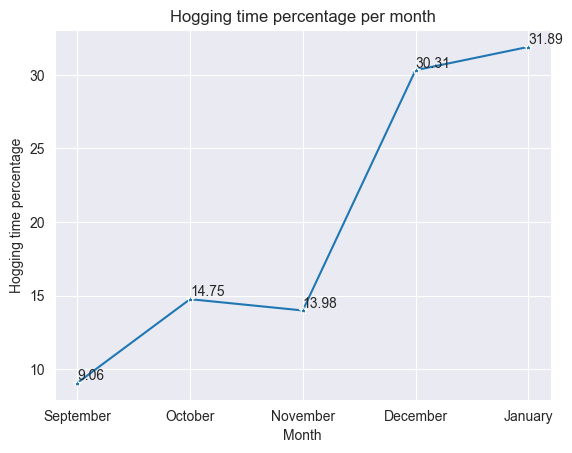

In [62]:
ax = sns.lineplot(
    data=user_data_hogging_month,
    x='Plugged_in_month',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*'
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
for i, (x_val, y_val) in enumerate(zip(user_data_hogging_month['Plugged_in_month'], user_data_hogging_month['Percentage'])):
    plt.text(i, y_val, f'{y_val:.2f}', ha='left', va='bottom')
plt.xlabel('Month')
plt.ylabel('Hogging time percentage')
plt.title('Hogging time percentage per month')

# Save figure
plt.savefig('P_images/hogging-time-percentage (month)', bbox_inches='tight')
plt.show()

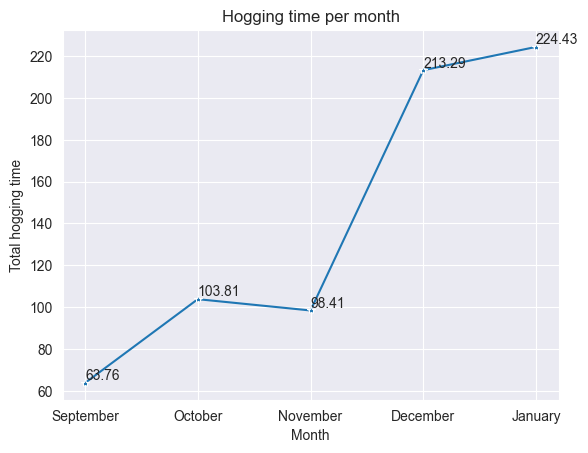

In [63]:
ax = sns.lineplot(
    data=user_data,
    x='Plugged_in_month',
    y='Hogging time',
    estimator='sum',
    ci=None,
    marker='*'
)
plt.xlabel('Month')
plt.ylabel('Total hogging time')
plt.title('Hogging time per month')
for i, (x_val, y_val) in enumerate(zip(user_data_hogging_month['Plugged_in_month'], user_data_hogging_month['Hogging time'])):
    plt.text(i, y_val, f'{y_val:.2f}', ha='left', va='bottom')

# Save figure
plt.savefig('P_images/hogging-time-per-month', bbox_inches='tight')
plt.show()

In [65]:
# Create a function to calculate the percentage hogging time per month
def get_hogging_time_percentage(month):
    user_data_month = user_data[user_data['Plugged_in_month'] == month]
    user_data_month = user_data_month.groupby('Plugged_in_dayname')['Hogging time'].sum().reset_index()
    user_data_month['Percentage'] = (user_data_month['Hogging time'] / user_data_month['Hogging time'].sum()) * 100
    return user_data_month

In [66]:
# Extract the hogging time percentage for each month
user_data_hogging_september = get_hogging_time_percentage('September')
user_data_hogging_october = get_hogging_time_percentage('October')
user_data_hogging_november = get_hogging_time_percentage('November')
user_data_hogging_december = get_hogging_time_percentage('December')
user_data_hogging_january = get_hogging_time_percentage('January')

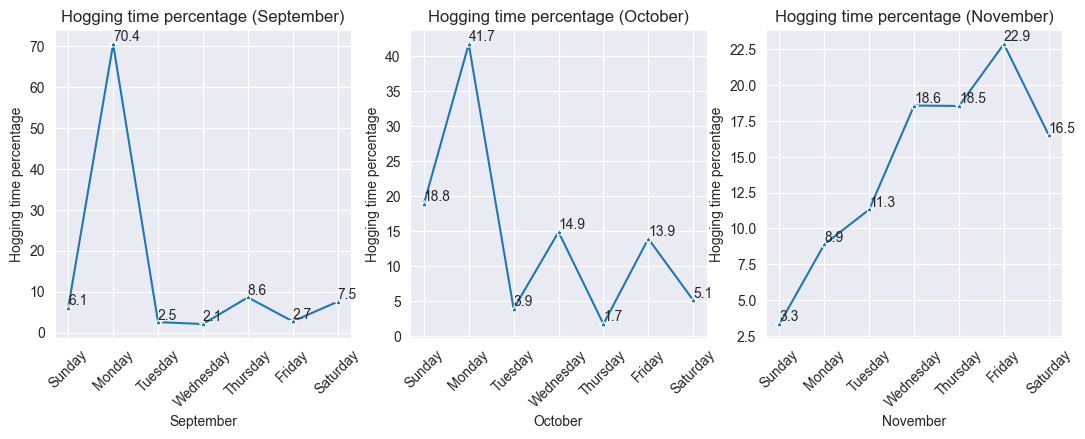

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.lineplot(
    data=user_data_hogging_september,
    x='Plugged_in_dayname',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*',
    ax=ax[0]
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
for i, (x_val, y_val) in enumerate(zip(user_data_hogging_september['Plugged_in_dayname'], user_data_hogging_september['Percentage'])):
    ax[0].text(i, y_val, f'{y_val:.1f}', ha='left', va='bottom')
ax[0].set_xlabel('September')
ax[0].set_ylabel('Hogging time percentage')
ax[0].set_title('Hogging time percentage (September)')
ax[0].tick_params(axis='x', rotation=45)

# October
sns.lineplot(
    data=user_data_hogging_october,
    x='Plugged_in_dayname',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*',
    ax=ax[1]
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
for i, (x_val, y_val) in enumerate(zip(user_data_hogging_october['Plugged_in_dayname'], user_data_hogging_october['Percentage'])):
    ax[1].text(i, y_val, f'{y_val:.1f}', ha='left', va='bottom')
ax[1].set_xlabel('October')
ax[1].set_ylabel('Hogging time percentage')
ax[1].set_title('Hogging time percentage (October)')
ax[1].tick_params(axis='x', rotation=45)

# November
sns.lineplot(
    data=user_data_hogging_november,
    x='Plugged_in_dayname',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*',
    ax=ax[2]
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
for i, (x_val, y_val) in enumerate(zip(user_data_hogging_november['Plugged_in_dayname'], user_data_hogging_november['Percentage'])):
    ax[2].text(i, y_val, f'{y_val:.1f}', ha='left', va='bottom')
ax[2].set_xlabel('November')
ax[2].set_ylabel('Hogging time percentage')
ax[2].set_title('Hogging time percentage (November)')
ax[2].tick_params(axis='x', rotation=45)

# Save figure
plt.savefig('P_images/hogging-time-percentage-per-month-1', bbox_inches='tight')
plt.show()

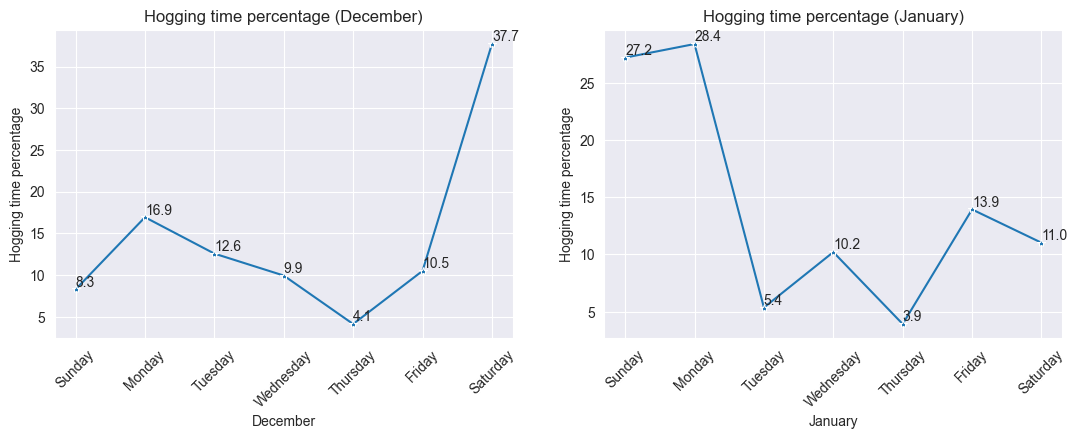

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.lineplot(
    data=user_data_hogging_december,
    x='Plugged_in_dayname',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*',
    ax=ax[0]
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
for i, (x_val, y_val) in enumerate(zip(user_data_hogging_december['Plugged_in_dayname'], user_data_hogging_december['Percentage'])):
    ax[0].text(i, y_val, f'{y_val:.1f}', ha='left', va='bottom')
ax[0].set_xlabel('December')
ax[0].set_ylabel('Hogging time percentage')
ax[0].set_title('Hogging time percentage (December)')
ax[0].tick_params(axis='x', rotation=45)

# January
sns.lineplot(
    data=user_data_hogging_january,
    x='Plugged_in_dayname',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*',
    ax=ax[1]
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
for i, (x_val, y_val) in enumerate(zip(user_data_hogging_january['Plugged_in_dayname'], user_data_hogging_january['Percentage'])):
    ax[1].text(i, y_val, f'{y_val:.1f}', ha='left', va='bottom')
ax[1].set_xlabel('January')
ax[1].set_ylabel('Hogging time percentage')
ax[1].set_title('Hogging time percentage (January)')
ax[1].tick_params(axis='x', rotation=45)

# Save figure
plt.savefig('P_images/hogging-time-percentage-per-month-2', bbox_inches='tight')
plt.show()

#### Calculate hogging time without outliers

In [69]:
# Obtain the hogging time for the corrected data
user_data_cc_september['Hogging time'] = user_data_cc_september['Blocking Time'] - user_data_cc_september['Charging Duration']
user_data_cc_october['Hogging time'] = user_data_cc_october['Blocking Time'] - user_data_cc_october['Charging Duration']
user_data_cc_november['Hogging time'] = user_data_cc_november['Blocking Time'] - user_data_cc_november['Charging Duration']
user_data_cc_december['Hogging time'] = user_data_cc_december['Blocking Time'] - user_data_cc_december['Charging Duration']
user_data_cc_january['Hogging time'] = user_data_cc_january['Blocking Time'] - user_data_cc_january['Charging Duration']

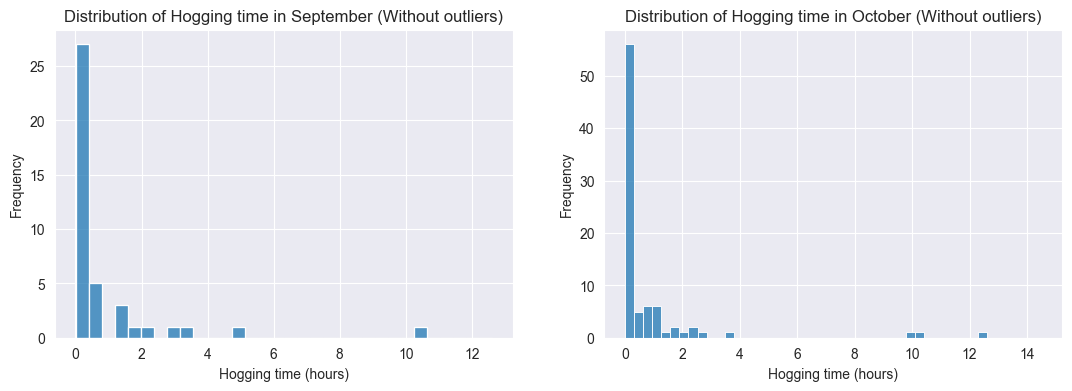

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_cc_september,
    x='Hogging time',
    ax=ax[0],
    binrange=(user_data_cc_september['Hogging time'].min(), user_data_cc_september['Hogging time'].max() + 2)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in September (Without outliers)')

# October
sns.histplot(
    data=user_data_cc_october,
    x='Hogging time',
    ax=ax[1],
    binrange=(user_data_cc_october['Hogging time'].min(), user_data_cc_october['Hogging time'].max() + 2)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in October (Without outliers)')

# Save figure
plt.savefig('P_images/hogging-time-distribution-1-without-outlier', bbox_inches='tight')
plt.show()

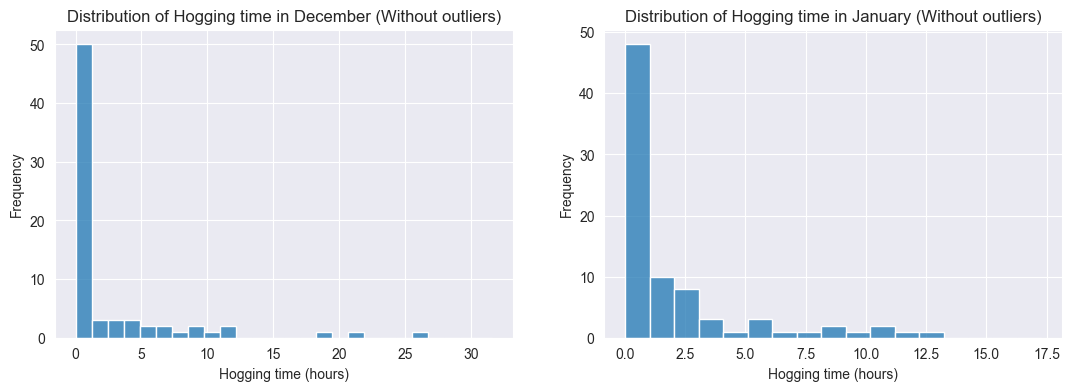

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_cc_december,
    x='Hogging time',
    ax=ax[0],
    binrange=(user_data_cc_december['Hogging time'].min(), user_data_cc_december['Hogging time'].max() + 5)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in December (Without outliers)')

# October
sns.histplot(
    data=user_data_cc_january,
    x='Hogging time',
    ax=ax[1],
    binrange=(user_data_cc_january['Hogging time'].min(), user_data_cc_january['Hogging time'].max() + 5)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in January (Without outliers)')

# Save figure
plt.savefig('P_images/hogging-time-distribution-2-without-outlier', bbox_inches='tight')
plt.show()

### Connection and Charge time (monthly)

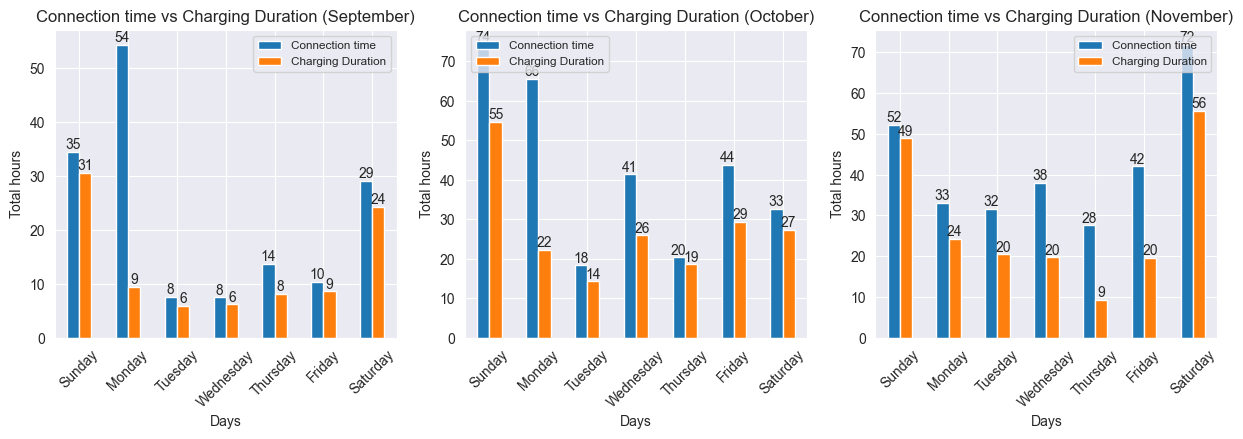

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# September
user_data_september.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Total hours')
ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection time vs Charging Duration (September)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# October
user_data_october.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Total hours')
ax[1].legend(['Connection time', 'Charging Duration'], loc='upper left', fontsize=8.5)
ax[1].set_title('Connection time vs Charging Duration (October)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# November
user_data_november.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[2])
#ax[2].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Total hours')
ax[2].legend(['Connection time', 'Charging Duration'], loc='upper right', fontsize=8.5)
ax[2].set_title('Connection time vs Charging Duration (November)')
ax[2].tick_params(axis='x', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=10, fmt='%.0f')
ax[2].bar_label(ax[2].containers[1], fontsize=10, fmt='%.0f')

# Save figure
plt.savefig('P_images/average-connection-charge-time-per-day-1', bbox_inches='tight')
plt.show()

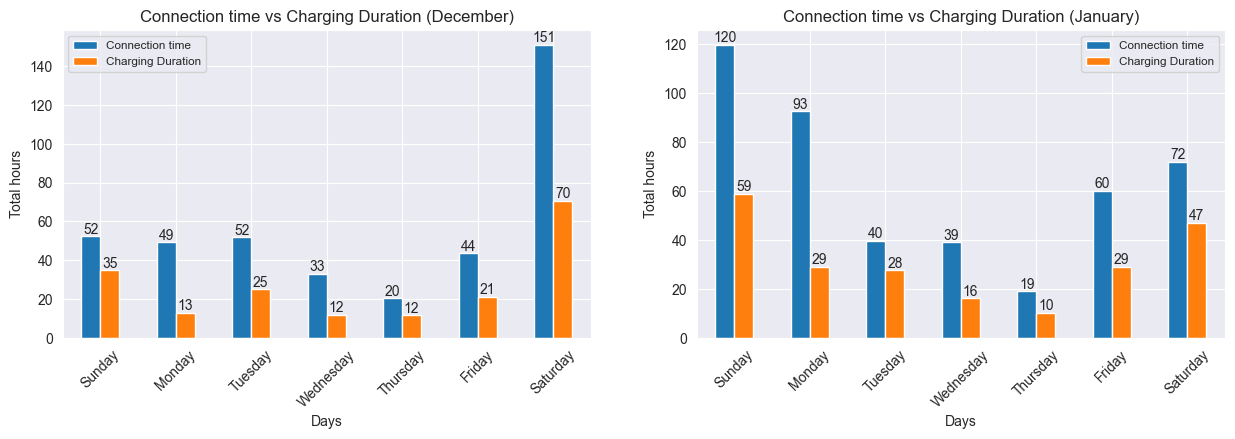

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# December
user_data_december.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Total hours')
ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection time vs Charging Duration (December)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# January
user_data_january.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Total hours')
ax[1].legend(['Connection time', 'Charging Duration'], loc='upper right', fontsize=8.5)
ax[1].set_title('Connection time vs Charging Duration (January)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# Save figure
plt.savefig('P_images/average-connection-charge-time-2', bbox_inches='tight')
plt.show()

#### Without outliers

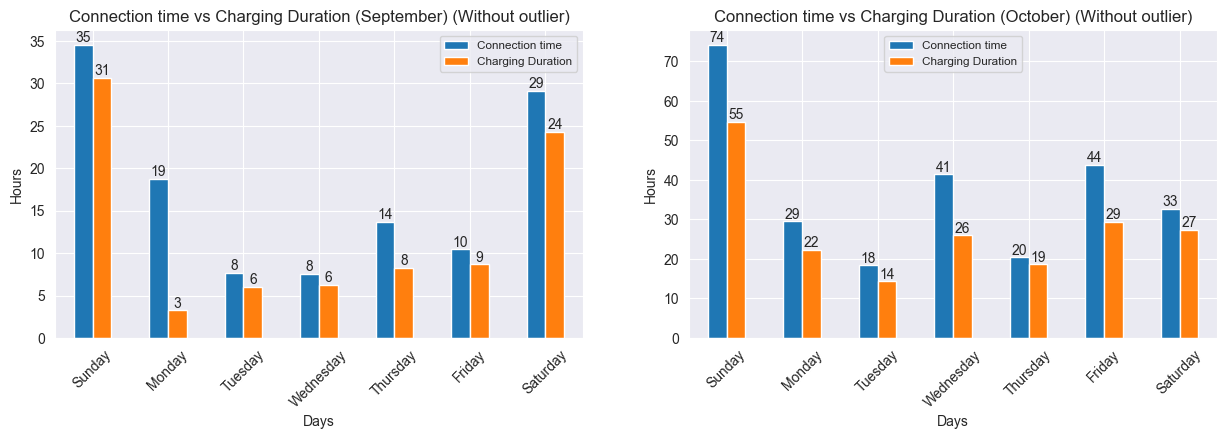

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# September
user_data_cc_september.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Hours')
ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection time vs Charging Duration (September) (Without outlier)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# October
user_data_cc_october.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Hours')
ax[1].legend(['Connection time', 'Charging Duration'], loc='upper center', fontsize=8.5)
ax[1].set_title('Connection time vs Charging Duration (October) (Without outlier)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# Save figure
plt.savefig('P_images/average-connection-charge-time-1-without-outlier', bbox_inches='tight')
plt.show()

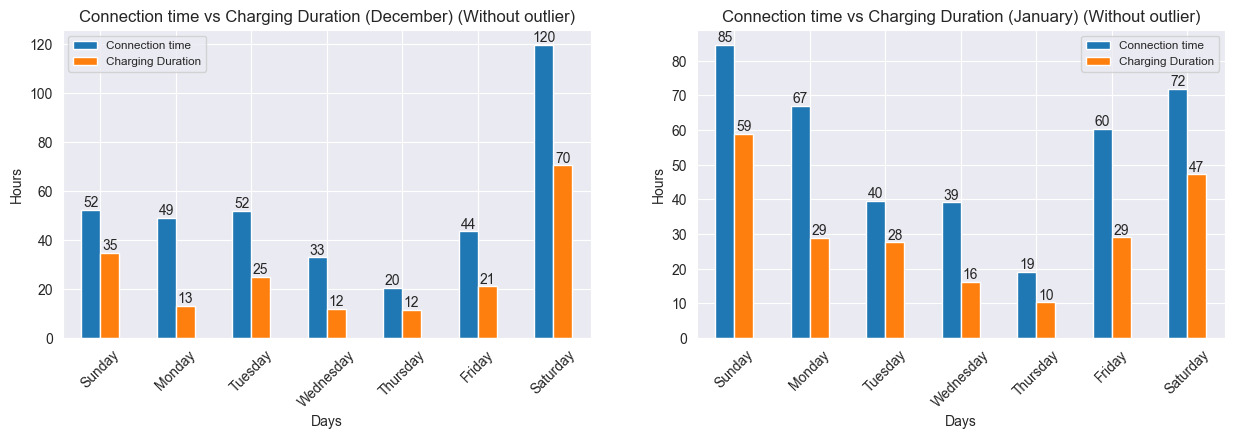

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# September
user_data_cc_december.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Hours')
ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection time vs Charging Duration (December) (Without outlier)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# October
user_data_cc_january.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Hours')
ax[1].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[1].set_title('Connection time vs Charging Duration (January) (Without outlier)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# Save figure
plt.savefig('P_images/average-connection-charge-time-2-without-outlier', bbox_inches='tight')
plt.show()

### Connection, Charge and Hogging time

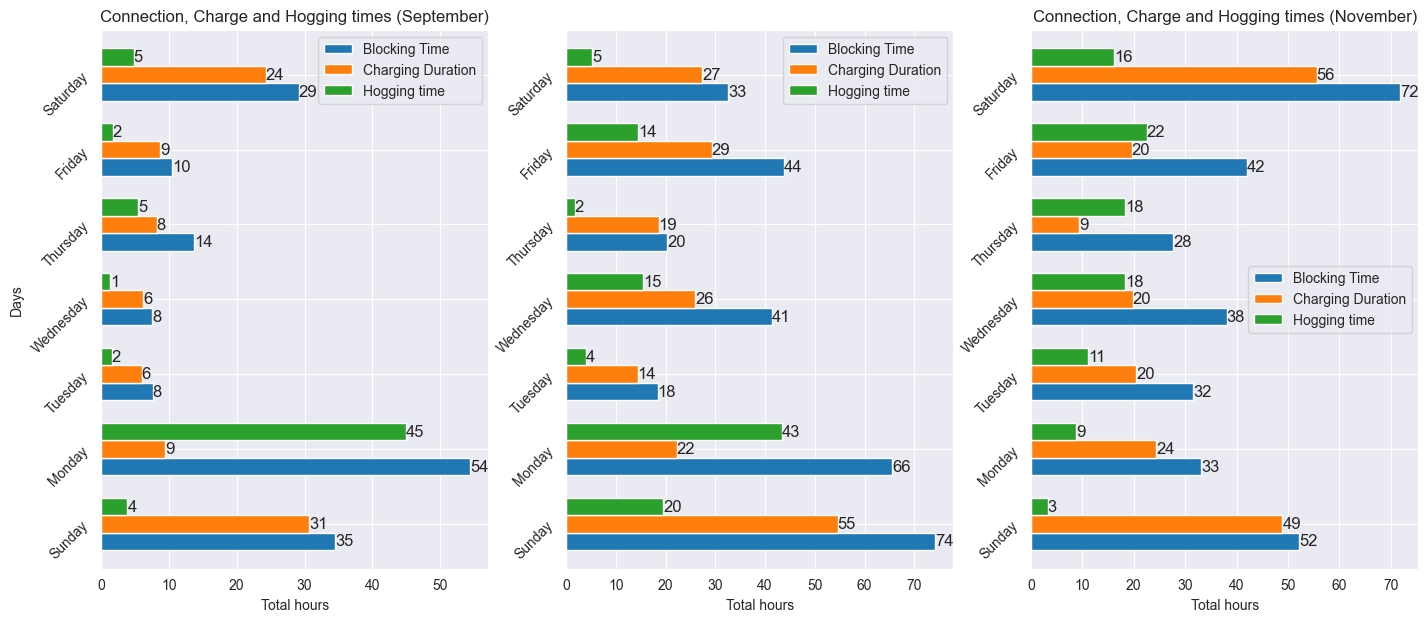

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(17, 7))

# September
user_data_september.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration', 'Hogging time']].sum().plot(kind='barh', ax=ax[0], width=0.7)
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[0].set_ylabel('Days')
ax[0].set_xlabel('Total hours')
#ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection, Charge and Hogging times (September)')
ax[0].tick_params(axis='y', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=12, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=12, fmt='%.0f')
ax[0].bar_label(ax[0].containers[2], fontsize=12, fmt='%.0f')
ax[0].legend(loc='upper right')

# October
user_data_october.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration', 'Hogging time']].sum().plot(kind='barh', ax=ax[1], width=0.7)
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_ylabel('') # Leave empty to give space in the graph
ax[1].set_xlabel('Total hours')
ax[1].legend(['Connection time', 'Charging Duration'], loc='upper left', fontsize=8.5)
#ax[1].set_title('Connection, Charge and Hogging times (October)')
ax[1].tick_params(axis='y', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=12, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=12, fmt='%.0f')
ax[1].bar_label(ax[1].containers[2], fontsize=12, fmt='%.0f')
ax[1].legend(loc='upper right')

# November
user_data_november.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration', 'Hogging time']].sum().plot(kind='barh', ax=ax[2], width=0.7)
#ax[2].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[2].set_ylabel('') # Leave empty to give space in the graph
ax[2].set_xlabel('Total hours')
#ax[2].legend(['Connection time', 'Charging Duration'], loc='upper right', fontsize=8.5)
ax[2].set_title('Connection, Charge and Hogging times (November)')
ax[2].tick_params(axis='y', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=12, fmt='%.0f')
ax[2].bar_label(ax[2].containers[1], fontsize=12, fmt='%.0f')
ax[2].bar_label(ax[2].containers[2], fontsize=12, fmt='%.0f')
ax[2].legend(loc='center right')

# Save figure
plt.savefig('P_images/connection-charge-hogging-time-per-day-1', bbox_inches='tight')
plt.show()

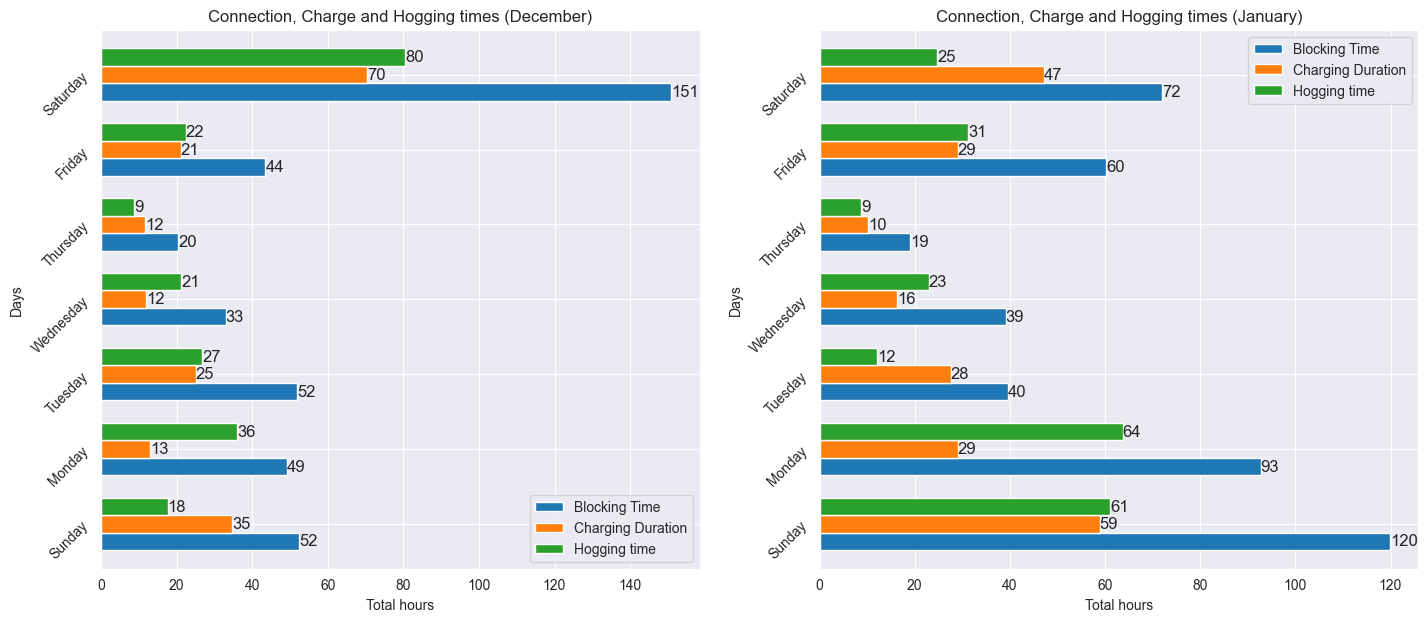

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

# December
user_data_december.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration', 'Hogging time']].sum().plot(kind='barh', ax=ax[0], width=0.7)
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[0].set_ylabel('Days')
ax[0].set_xlabel('Total hours')
ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection, Charge and Hogging times (December)')
ax[0].tick_params(axis='y', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=12, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=12, fmt='%.0f')
ax[0].bar_label(ax[0].containers[2], fontsize=12, fmt='%.0f')
ax[0].legend(loc='lower right')

# January
user_data_january.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration', 'Hogging time']].sum().plot(kind='barh', ax=ax[1], width=0.7)
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_ylabel('Days')
ax[1].set_xlabel('Total hours')
ax[1].legend(['Connection time', 'Charging Duration'], loc='upper left', fontsize=8.5)
ax[1].set_title('Connection, Charge and Hogging times (January)')
ax[1].tick_params(axis='y', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=12, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=12, fmt='%.0f')
ax[1].bar_label(ax[1].containers[2], fontsize=12, fmt='%.0f')
ax[1].legend(loc='upper right')

# Save figure
plt.savefig('P_images/connection-charge-hogging-time-per-day-2', bbox_inches='tight')
plt.show()

#### Without outliers

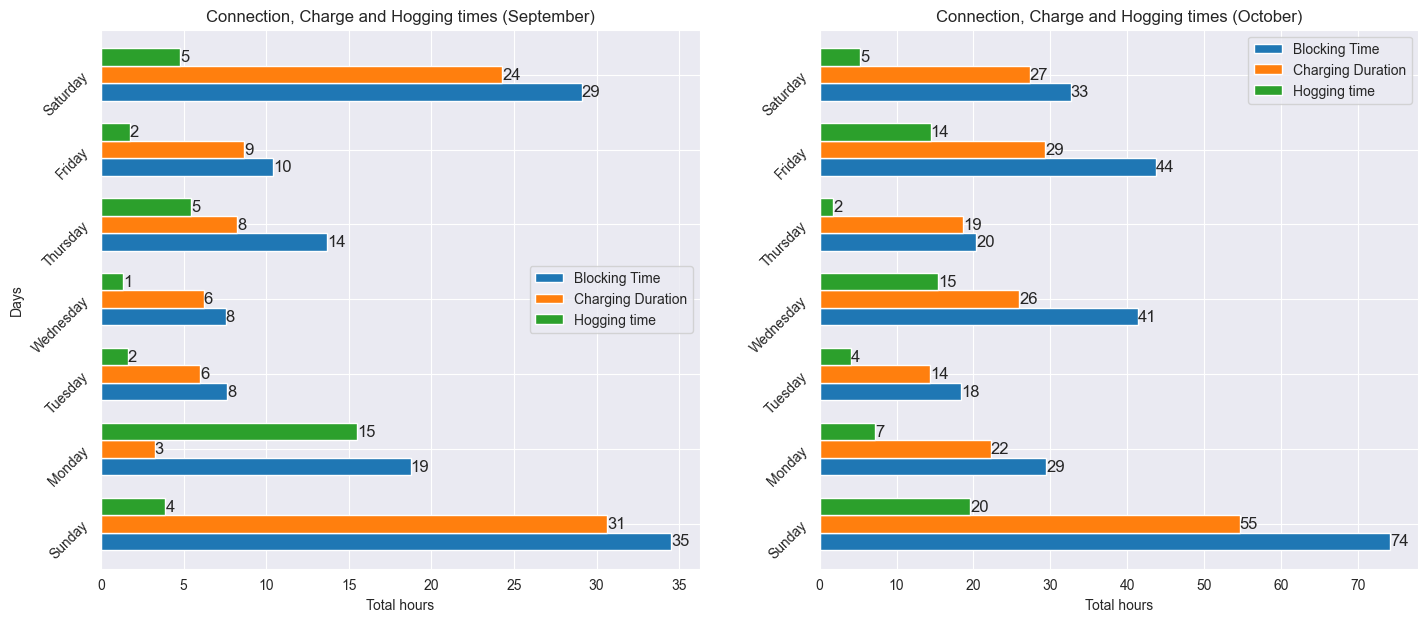

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

# September
user_data_cc_september.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration', 'Hogging time']].sum().plot(kind='barh', ax=ax[0], width=0.7)
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[0].set_ylabel('Days')
ax[0].set_xlabel('Total hours')
#ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection, Charge and Hogging times (September)')
ax[0].tick_params(axis='y', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=12, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=12, fmt='%.0f')
ax[0].bar_label(ax[0].containers[2], fontsize=12, fmt='%.0f')
ax[0].legend(loc='center right')

# October
user_data_cc_october.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration', 'Hogging time']].sum().plot(kind='barh', ax=ax[1], width=0.7)
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_ylabel('') # Leave empty to give space in the graph
ax[1].set_xlabel('Total hours')
ax[1].legend(['Connection time', 'Charging Duration'], loc='upper left', fontsize=8.5)
ax[1].set_title('Connection, Charge and Hogging times (October)')
ax[1].tick_params(axis='y', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=12, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=12, fmt='%.0f')
ax[1].bar_label(ax[1].containers[2], fontsize=12, fmt='%.0f')
ax[1].legend(loc='upper right')

# Save figure
plt.savefig('P_images/connection-charge-hogging-time-per-day-1-without-outlier', bbox_inches='tight')
plt.show()

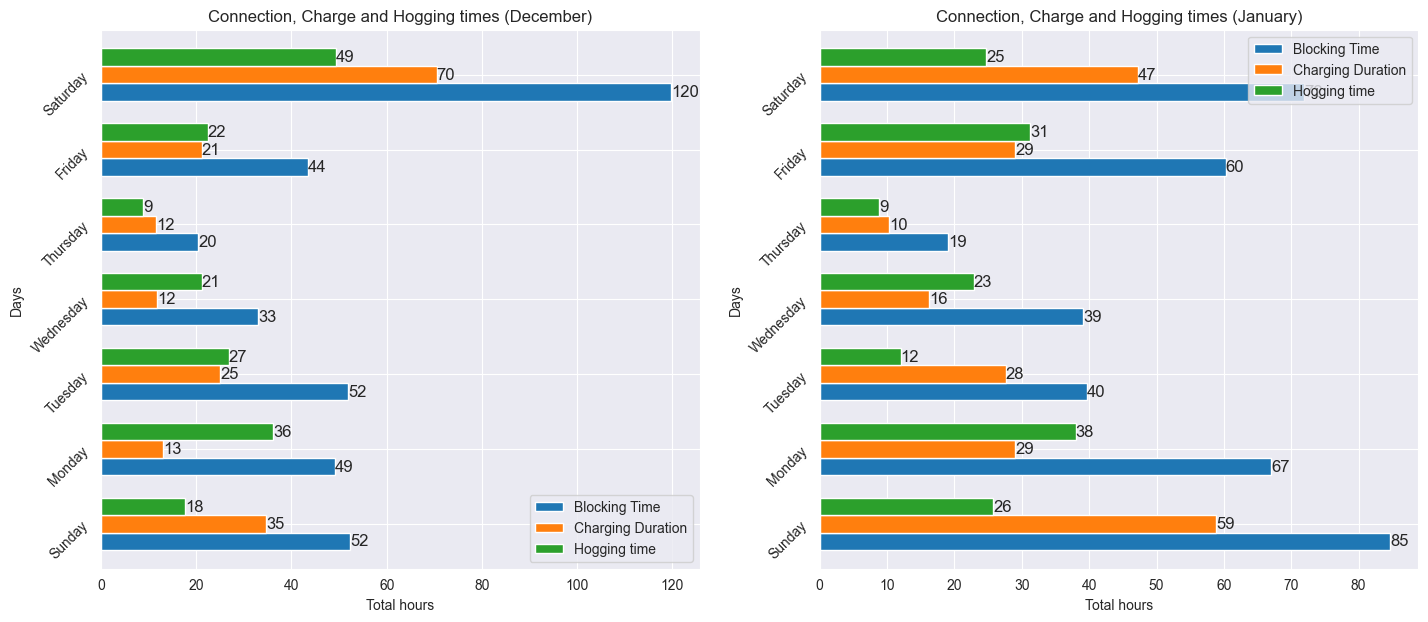

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

# December
user_data_cc_december.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration', 'Hogging time']].sum().plot(kind='barh', ax=ax[0], width=0.7)
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[0].set_ylabel('Days')
ax[0].set_xlabel('Total hours')
ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection, Charge and Hogging times (December)')
ax[0].tick_params(axis='y', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=12, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=12, fmt='%.0f')
ax[0].bar_label(ax[0].containers[2], fontsize=12, fmt='%.0f')
ax[0].legend(loc='lower right')

# January
user_data_cc_january.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration', 'Hogging time']].sum().plot(kind='barh', ax=ax[1], width=0.7)
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_ylabel('Days')
ax[1].set_xlabel('Total hours')
ax[1].legend(['Connection time', 'Charging Duration'], loc='upper left', fontsize=8.5)
ax[1].set_title('Connection, Charge and Hogging times (January)')
ax[1].tick_params(axis='y', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=12, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=12, fmt='%.0f')
ax[1].bar_label(ax[1].containers[2], fontsize=12, fmt='%.0f')
ax[1].legend(loc='upper right')

# Save figure
plt.savefig('P_images/connection-charge-hogging-time-per-day-2-without-outlier', bbox_inches='tight')
plt.show()

### Number of Charge sessions

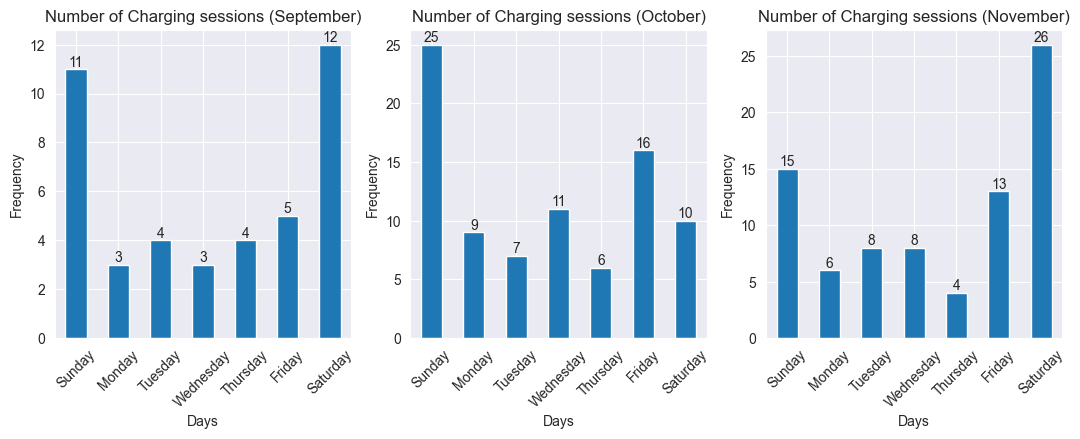

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))

# September
user_data_september.groupby('Plugged_in_dayname')['Charging Duration'].count().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Number of Charging sessions (September)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10)

# October
user_data_october.groupby('Plugged_in_dayname')['Charging Duration'].count().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Number of Charging sessions (October)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10)

# November
user_data_november.groupby('Plugged_in_dayname')['Charging Duration'].count().plot(kind='bar', ax=ax[2])
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Number of Charging sessions (November)')
ax[2].tick_params(axis='x', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=10)

# Save figure
plt.savefig('P_images/charge-sessions-per-day-1', bbox_inches='tight')
plt.show()

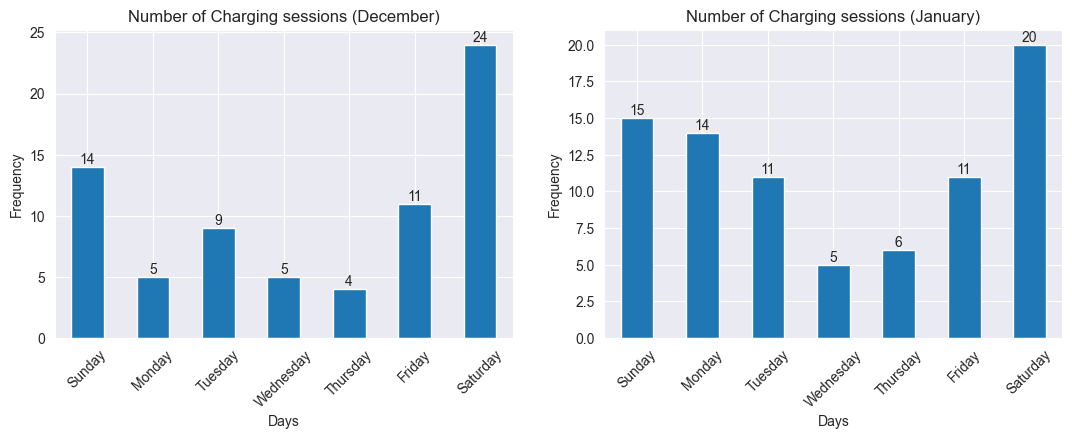

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# December
user_data_december.groupby('Plugged_in_dayname')['Charging Duration'].count().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Number of Charging sessions (December)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10)

# January
user_data_january.groupby('Plugged_in_dayname')['Charging Duration'].count().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Number of Charging sessions (January)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10)

# Save figure
plt.savefig('P_images/charge-sessions-per-day-2', bbox_inches='tight')
plt.show()

### 100% stacked bar chart

In [82]:
# A function to group the time into intervals
def groupby_by_time_interval(df):
    if df['Blocking Time'] <= 4:
        time_interval = '0-4 hours'
    elif df['Blocking Time'] > 4 and df['Blocking Time'] <=8:
        time_interval = '4-8 hours'
    elif df['Blocking Time'] > 8 and df['Blocking Time'] <= 16:
        time_interval = '8-16 hours'
    elif df['Blocking Time'] > 16 and df['Blocking Time'] <= 24:
        time_interval = '16-24 hours'
    elif df['Blocking Time'] > 24 and df['Blocking Time'] <= 48:
        time_interval = '24-48 hours'
    elif df['Blocking Time'] > 48 and df['Blocking Time'] <= 72:
        time_interval = '48-72 hours'
    else:
        time_interval = '72+ hours'
    return time_interval

In [83]:
# Convert the time intervals to a categorical data
u_c = user_data.copy()
u_c['Time interval'] = u_c.apply(groupby_by_time_interval, axis=1)
u_c['Time interval'] = pd.Categorical(
    u_c['Time interval'],
    categories=['0-4 hours', '4-8 hours', '8-16 hours', '16-24 hours', '24-48 hours', '48-72 hours', '72+ hours']
)

In [84]:
# Get the percentage charge session for each interval
u_c_sessions_reset = u_c['Time interval'].value_counts(normalize=True).reset_index()
u_c_sessions_reset.rename(columns={'proportion': 'Number of charge sessions'}, inplace=True)
u_c_sessions_reset['Number of charge sessions'] = u_c_sessions_reset['Number of charge sessions'] * 100

# Get the percentage connection time for each interval
u_c_blocking_time_reset = u_c.groupby('Time interval')['Blocking Time'].sum().reset_index()
u_c_blocking_time_reset['Blocking Time'] = (u_c_blocking_time_reset['Blocking Time'] / u_c_blocking_time_reset['Blocking Time'].sum()) * 100
u_c_blocking_time_reset.rename(columns={'Blocking Time': 'Connection Time'}, inplace=True)

u_c_reset = u_c_sessions_reset.merge(u_c_blocking_time_reset, on='Time interval', how='inner')

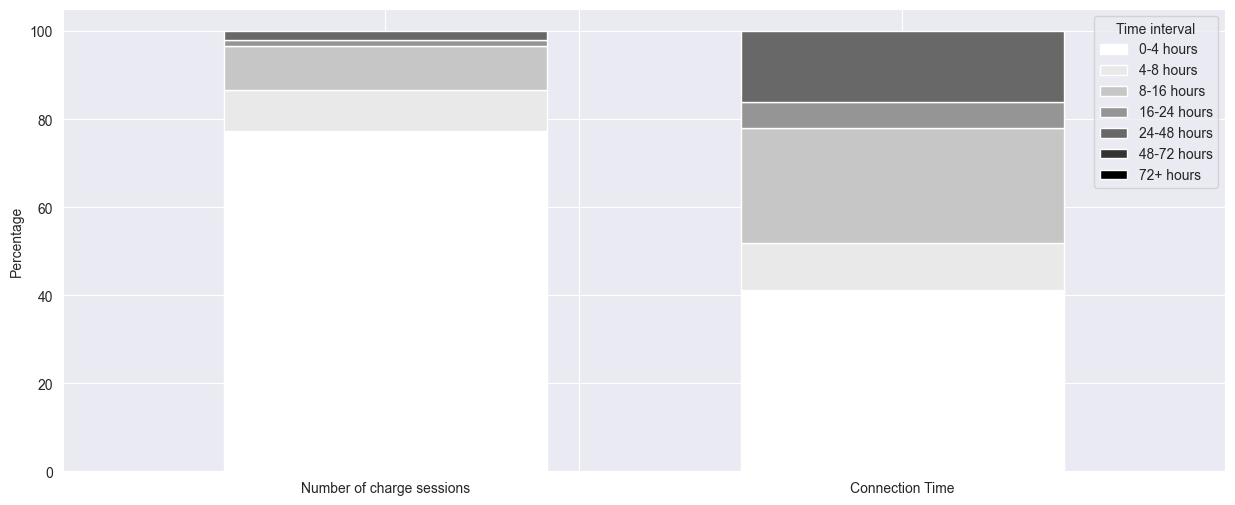

In [85]:
ax_proportion = u_c_reset.pivot_table(columns='Time interval', values='Number of charge sessions')
ax_blocking_time = u_c_reset.pivot_table(columns='Time interval', values='Connection Time')

# Create figure and axes objects
fig, axes = plt.subplots(1, 2, figsize=(15,6), sharey=True)

# Remove horizontal space between both plots
plt.subplots_adjust(wspace=-0.2)

# Plot number of charge sessions
ax_proportion.plot.bar(stacked=True, rot=0, cmap='Greys', ax=axes[0])
axes[0].get_legend().remove()
axes[0].set_ylabel('Percentage')

# Plot connection time
ax_blocking_time.plot.bar(stacked=True, rot=0, cmap='Greys', ax=axes[1])

plt.savefig('P_images/stacked-bar-chart-sessions-and-connection-time')
plt.show()

In [86]:
u_c_reset

,Time interval,Number of charge sessions,Connection Time
0,0-4 hours,77.222222,41.135295
1,8-16 hours,10.000000,26.162891
2,4-8 hours,9.444444,10.807972
3,24-48 hours,1.944444,16.186854
4,16-24 hours,1.388889,5.706989
5,48-72 hours,0.000000,0.000000
6,72+ hours,0.000000,0.000000


### Number of charge sessions by plug-in and unplugged times

In [87]:
# Obtain the session count for plug-in and plug-out times
plug_in = user_data.groupby(['Plugged_in_time_hour'])['Plugged_in_time_hour'].value_counts(dropna=False).reset_index()
plug_out = user_data.groupby(['Unplugged_time_hour'])['Unplugged_time_hour'].value_counts(dropna=False).reset_index()

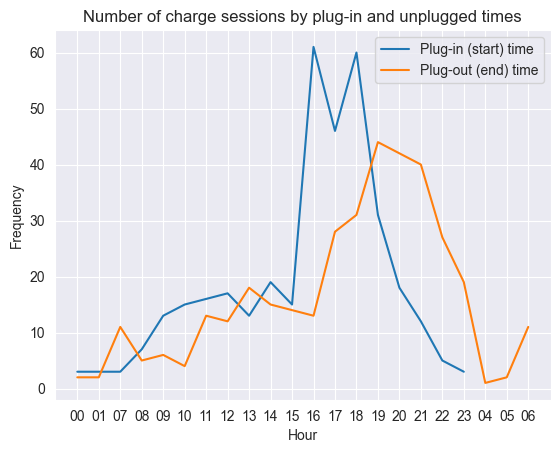

In [88]:
sns.lineplot(
    data=plug_in,
    x='Plugged_in_time_hour',
    y='count',
    label='Plug-in (start) time',
)
sns.lineplot(
    data=plug_out,
    x='Unplugged_time_hour',
    y='count',
    label='Plug-out (end) time',
)
plt.title('Number of charge sessions by plug-in and unplugged times')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.legend()

# Save figure
plt.savefig('P_images/number-of-charge-sessions-per-plugin-unplugged-times', bbox_inches='tight')
plt.show()

### Consumption per month

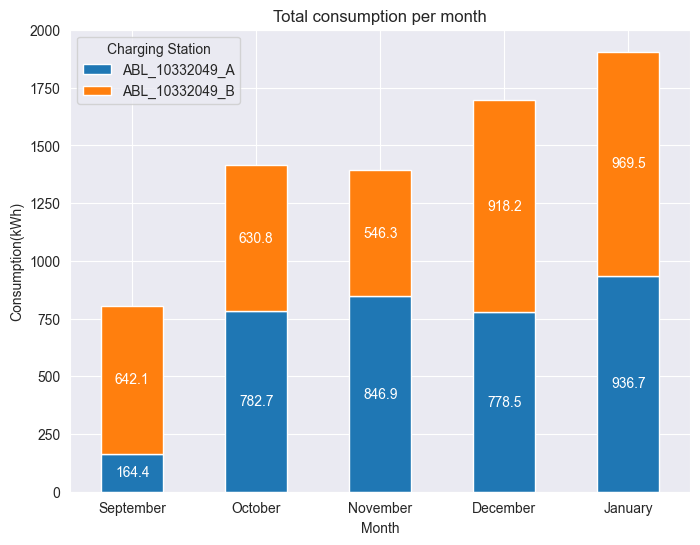

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of consumption per month using charging stations
df = user_data.pivot_table(index='Plugged_in_month', columns='Charging Station', values='Consumption(kWh)', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=0)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Month')
ax.set_title('Total consumption per month')

# Save figure
plt.savefig('P_images/consumption-per-month', bbox_inches='tight')
plt.show()

#### Without outliers

In [91]:
# Join the five months dataframes to a single one reflecting the corrected outliers
user_data_cc_concat = pd.concat([
    user_data_cc_september,
    user_data_cc_october,
    user_data_cc_november,
    user_data_cc_december,
    user_data_cc_january
], axis=0)

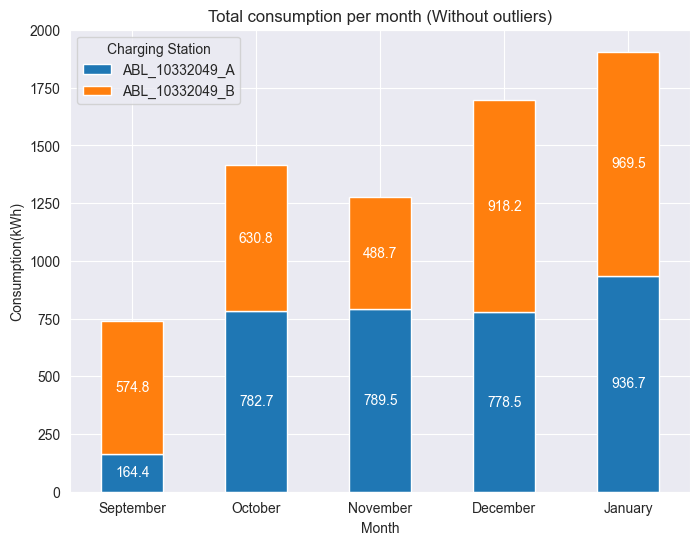

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of consumption per month using charging stations
df = user_data_cc_concat.pivot_table(index='Plugged_in_month', columns='Charging Station', values='Consumption(kWh)', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=0)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Month')
ax.set_title('Total consumption per month (Without outliers)')

# Save figure
plt.savefig('P_images/consumption-per-month-without-outlier', bbox_inches='tight')
plt.show()

In [93]:
user_data.groupby(['Plugged_in_month'])['Consumption(kWh)'].sum()

Plugged_in_month
September     806.527
October      1413.450
November     1393.269
December     1696.735
January      1906.173
Name: Consumption(kWh), dtype: float64

In [94]:
# Consumption per month for corrected data (Without outliers)
user_data_cc_concat.groupby(['Plugged_in_month'])['Consumption(kWh)'].sum()

Plugged_in_month
September     739.185000
October      1413.450000
November     1278.161857
December     1696.735000
January      1906.173000
Name: Consumption(kWh), dtype: float64

In [95]:
print(f"The total energy consumption for employees is {user_data_cc_concat['Consumption(kWh)'].sum()}")

The total energy consumption for employees is 7033.704857142859


### Consumption per Charging Station

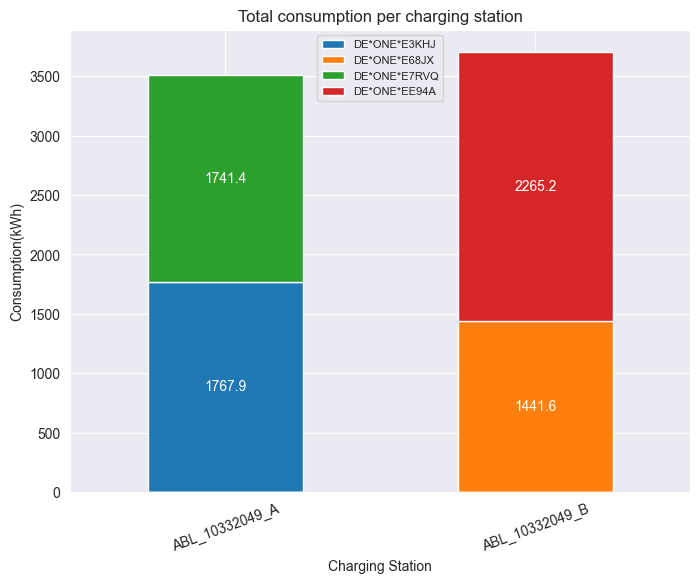

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of consumption per charging station using charging point
df = user_data.pivot_table(index='Charging Station', columns='EVSE-ID', values='Consumption(kWh)', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Charging Station')
ax.set_title('Total consumption per charging station')
ax.legend(loc='upper center', fontsize=8)

# Save figure
plt.savefig('P_images/consumption-per-charge-station', bbox_inches='tight')
plt.show()

#### Without outtliers

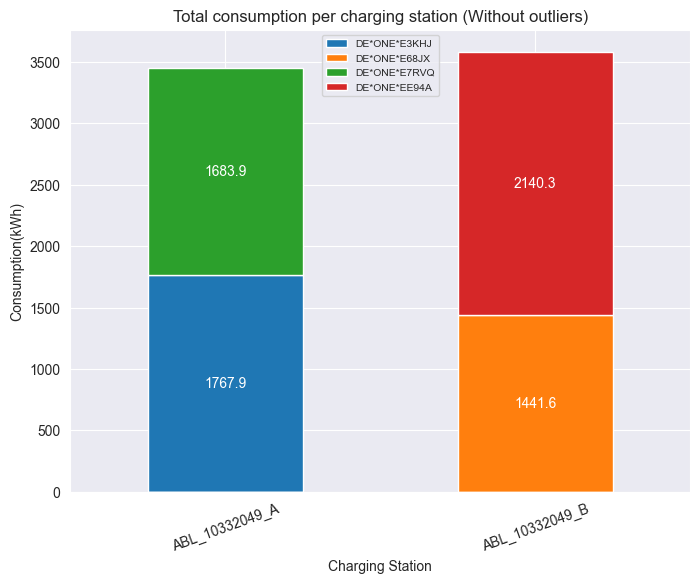

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of consumption per charging station using charging point
df = user_data_cc_concat.pivot_table(index='Charging Station', columns='EVSE-ID', values='Consumption(kWh)', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Charging Station')
ax.set_title('Total consumption per charging station (Without outliers)')
ax.legend(loc='upper center', fontsize=7.5)

# Save figure
plt.savefig('P_images/consumption-per-charge-station-without-outlier', bbox_inches='tight')
plt.show()

### Consumption per charge point

In [98]:
# Consumption per charge points
user_data.groupby(['Location', 'Charging Station', 'EVSE-ID'])['Consumption(kWh)'].sum()

Location  Charging Station  EVSE-ID     
Ulanweg   ABL_10332049_A    DE*ONE*E3KHJ    1767.912
                            DE*ONE*E7RVQ    1741.386
          ABL_10332049_B    DE*ONE*E68JX    1441.633
                            DE*ONE*EE94A    2265.223
Name: Consumption(kWh), dtype: float64

In [99]:
# Consumption per charge points for corrected data (Without outliers)
user_data_cc_concat.groupby(['Location', 'Charging Station', 'EVSE-ID'])['Consumption(kWh)'].sum()

Location  Charging Station  EVSE-ID     
Ulanweg   ABL_10332049_A    DE*ONE*E3KHJ    1767.912000
                            DE*ONE*E7RVQ    1683.897000
          ABL_10332049_B    DE*ONE*E68JX    1441.633000
                            DE*ONE*EE94A    2140.262857
Name: Consumption(kWh), dtype: float64

### Connection time per month

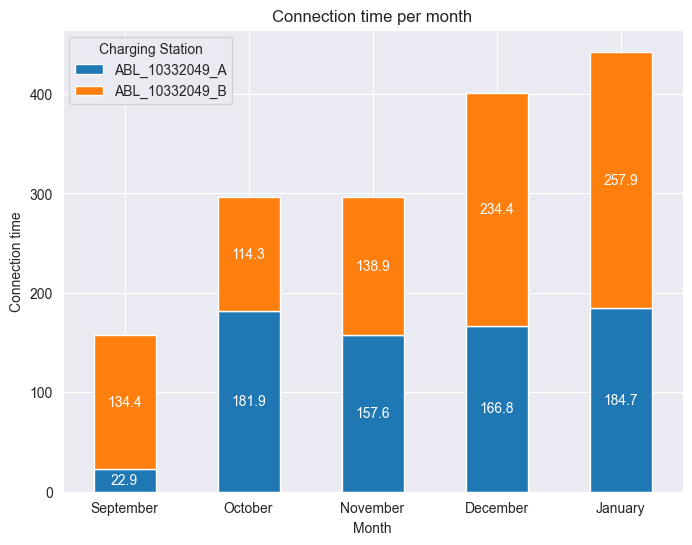

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of connection time per month using charging stations
df = user_data.pivot_table(index='Plugged_in_month', columns='Charging Station', values='Blocking Time', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=0)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Connection time')
ax.set_xlabel('Month')
ax.set_title('Connection time per month')

# Save figure
plt.savefig('P_images/connection-time-per-month', bbox_inches='tight')
plt.show()

### Without outliers

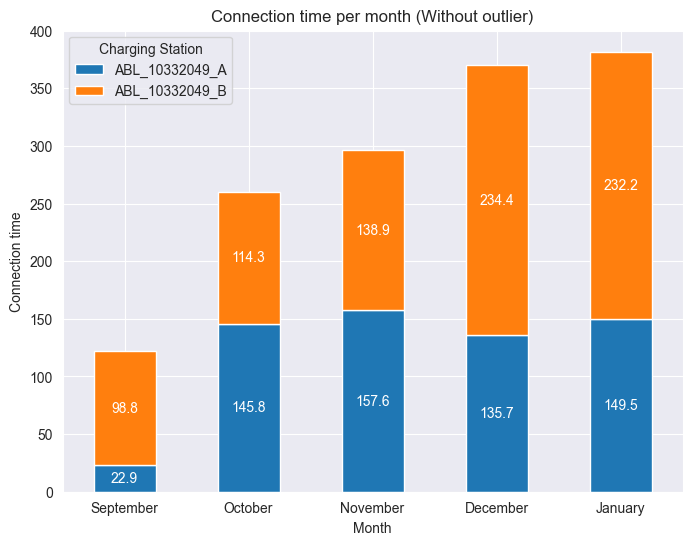

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of connection time per month using charging stations
df = user_data_cc_concat.pivot_table(index='Plugged_in_month', columns='Charging Station', values='Blocking Time', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=0)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Connection time')
ax.set_xlabel('Month')
ax.set_title('Connection time per month (Without outlier)')

# Save figure
plt.savefig('P_images/connection-time-per-month-without-outlier', bbox_inches='tight')
plt.show()

In [102]:
user_data.groupby('Plugged_in_month')['Blocking Time'].sum()

Plugged_in_month
September    157.323056
October      296.234722
November     296.518333
December     401.236944
January      442.595278
Name: Blocking Time, dtype: float64

In [103]:
user_data_cc_concat.groupby('Plugged_in_month')['Blocking Time'].sum()

Plugged_in_month
September    121.695556
October      260.179444
November     296.518333
December     370.091914
January      381.652361
Name: Blocking Time, dtype: float64

### Connection time per charge station

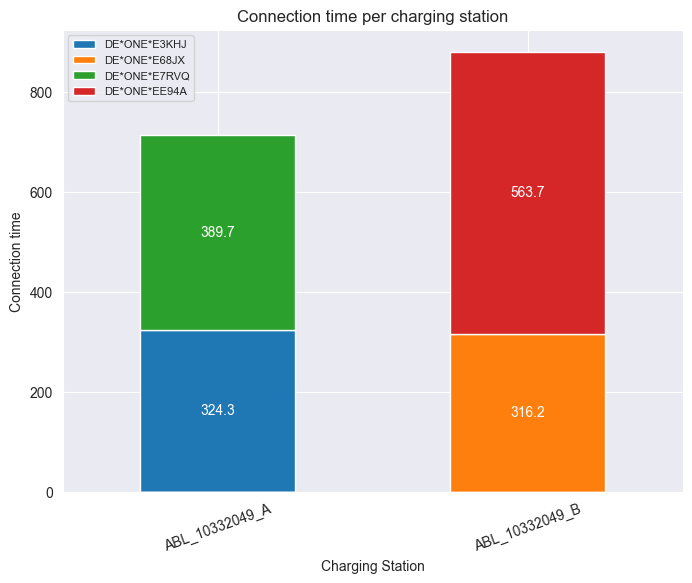

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of connection time per charging station using charging points
df = user_data.pivot_table(index='Charging Station', columns='EVSE-ID', values='Blocking Time', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Connection time')
ax.set_xlabel('Charging Station')
ax.set_title('Connection time per charging station')
ax.legend(loc='upper left', fontsize=8)

# Save figure
plt.savefig('P_images/connection-time-per-charge-station', bbox_inches='tight')
plt.show()

#### Without outliers

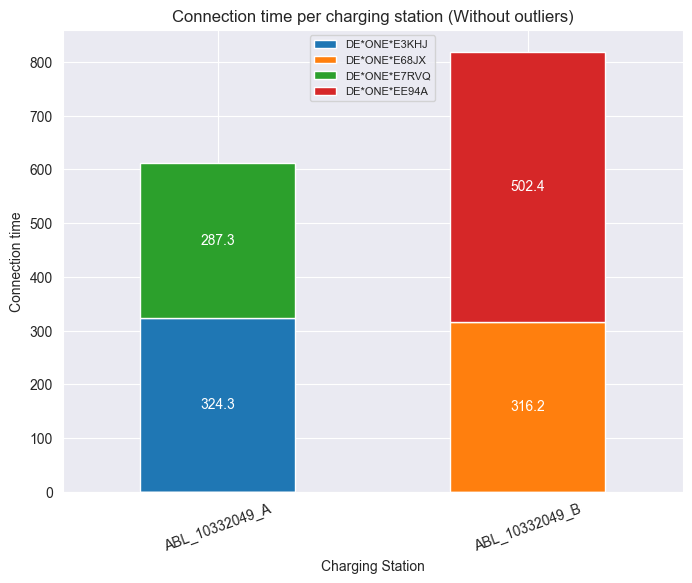

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of connection time per charging station using charging points
df = user_data_cc_concat.pivot_table(index='Charging Station', columns='EVSE-ID', values='Blocking Time', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Connection time')
ax.set_xlabel('Charging Station')
ax.set_title('Connection time per charging station (Without outliers)')
ax.legend(loc='upper center', fontsize=8)

# Save figure
plt.savefig('P_images/connection-time-per-charge-station-without-outlier', bbox_inches='tight')
plt.show()

In [106]:
user_data.groupby(['Location', 'Charging Station', 'EVSE-ID'])['Blocking Time'].sum()

Location  Charging Station  EVSE-ID     
Ulanweg   ABL_10332049_A    DE*ONE*E3KHJ    324.255833
                            DE*ONE*E7RVQ    389.696667
          ABL_10332049_B    DE*ONE*E68JX    316.225833
                            DE*ONE*EE94A    563.730000
Name: Blocking Time, dtype: float64

In [107]:
user_data_cc_concat.groupby(['Location', 'Charging Station', 'EVSE-ID'])['Blocking Time'].sum()

Location  Charging Station  EVSE-ID     
Ulanweg   ABL_10332049_A    DE*ONE*E3KHJ    324.255833
                            DE*ONE*E7RVQ    287.258580
          ABL_10332049_B    DE*ONE*E68JX    316.225833
                            DE*ONE*EE94A    502.397361
Name: Blocking Time, dtype: float64

### Charge time per month

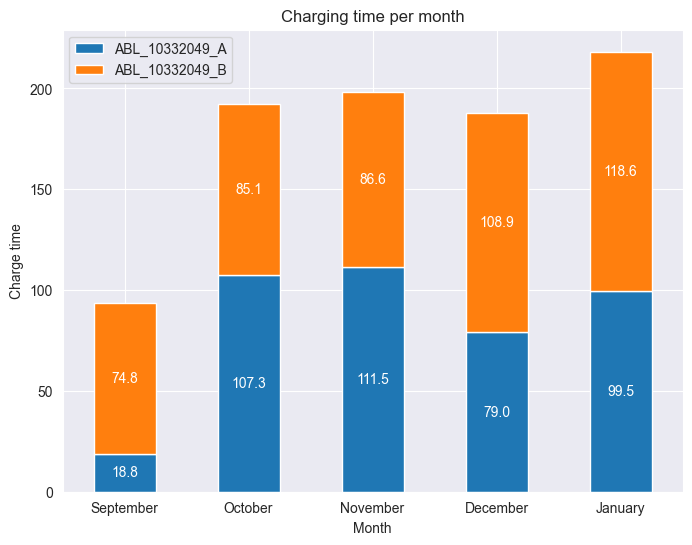

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of charging time per month using charging stations
df = user_data.pivot_table(index='Plugged_in_month', columns='Charging Station', values='Charging Duration', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=0)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Charge time')
ax.set_xlabel('Month')
ax.set_title('Charging time per month')
ax.legend(loc='upper left')

# Save figure
plt.savefig('P_images/charge-time-per-month', bbox_inches='tight')
plt.show()

### Without outliers

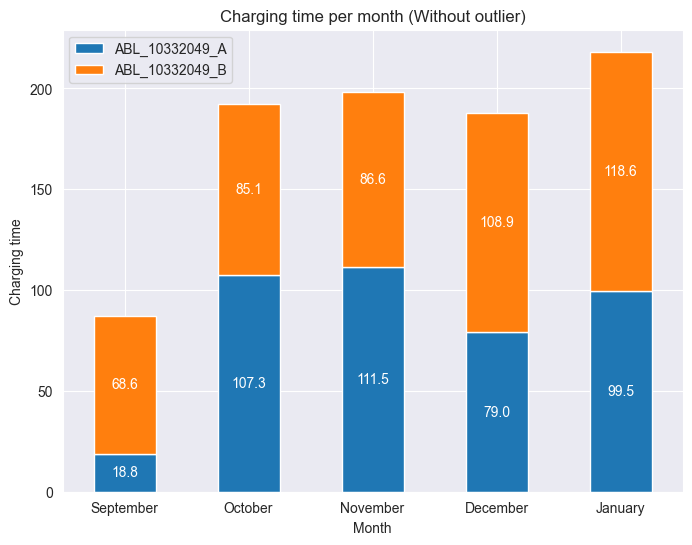

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of charging time per month using charging stations
df = user_data_cc_concat.pivot_table(index='Plugged_in_month', columns='Charging Station', values='Charging Duration', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=0)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Charging time')
ax.set_xlabel('Month')
ax.set_title('Charging time per month (Without outlier)')
ax.legend(loc='upper left')

# Save figure
plt.savefig('P_images/charge-time-per-month-without-outlier', bbox_inches='tight')
plt.show()

In [110]:
user_data.groupby('Plugged_in_month')['Charging Duration'].sum()

Plugged_in_month
September     93.561389
October      192.427778
November     198.110833
December     187.942500
January      218.163333
Name: Charging Duration, dtype: float64

In [111]:
user_data_cc_concat.groupby('Plugged_in_month')['Charging Duration'].sum()

Plugged_in_month
September     87.359444
October      192.427778
November     198.110833
December     187.942500
January      218.163333
Name: Charging Duration, dtype: float64

In [195]:
user_data_cc_concat['Consumption(kWh)'].sum()

7033.704857142859

### Charge time per charge station

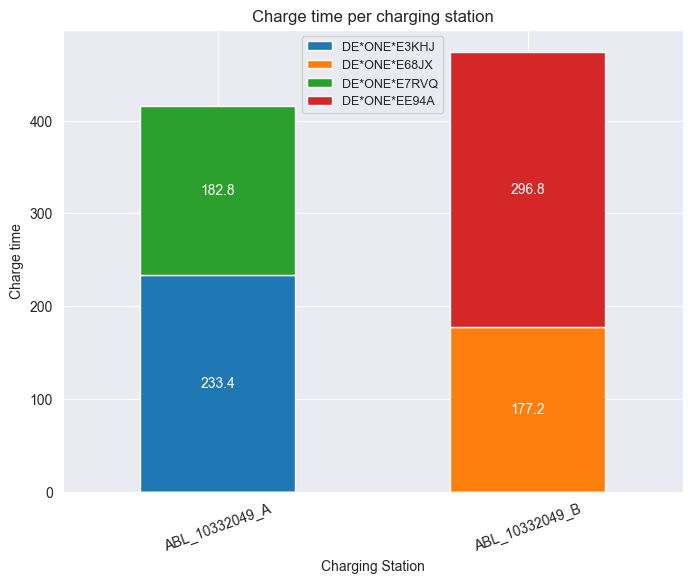

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of charge time per charging station using charging pointss
df = user_data.pivot_table(index='Charging Station', columns='EVSE-ID', values='Charging Duration', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Charge time')
ax.set_xlabel('Charging Station')
ax.set_title('Charge time per charging station')
ax.legend(loc='upper center', fontsize=9)

# Save figure
plt.savefig('P_images/charge-time-per-charge-station', bbox_inches='tight')
plt.show()

#### Without outliers

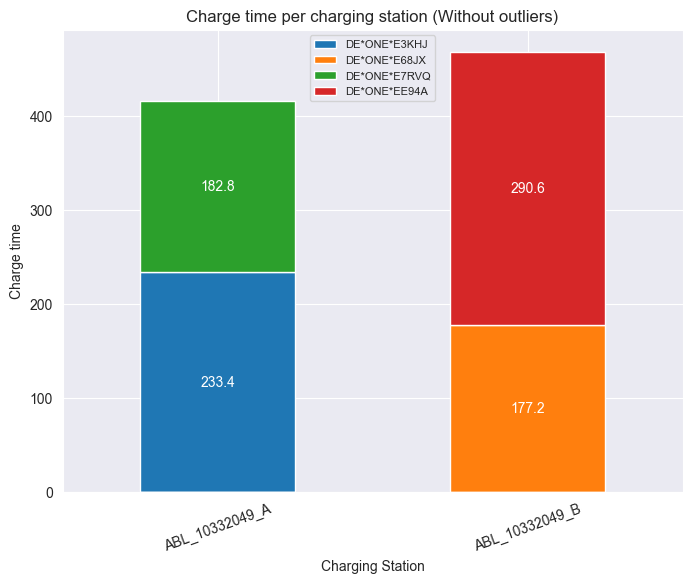

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of charge time per charging station using charging pointss
df = user_data_cc_concat.pivot_table(index='Charging Station', columns='EVSE-ID', values='Charging Duration', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Charge time')
ax.set_xlabel('Charging Station')
ax.set_title('Charge time per charging station (Without outliers)')
ax.legend(loc='upper center', fontsize=8)

# Save figure
plt.savefig('P_images/charge-time-per-charge-station-without-outlier', bbox_inches='tight')
plt.show()

In [114]:
user_data.groupby('Charging Station')['Charging Duration'].sum()

Charging Station
ABL_10332049_A    416.143333
ABL_10332049_B    474.062500
Name: Charging Duration, dtype: float64

In [115]:
user_data_cc_concat.groupby('Charging Station')['Charging Duration'].sum()

Charging Station
ABL_10332049_A    416.143333
ABL_10332049_B    467.860556
Name: Charging Duration, dtype: float64

### Hogging time per charge station

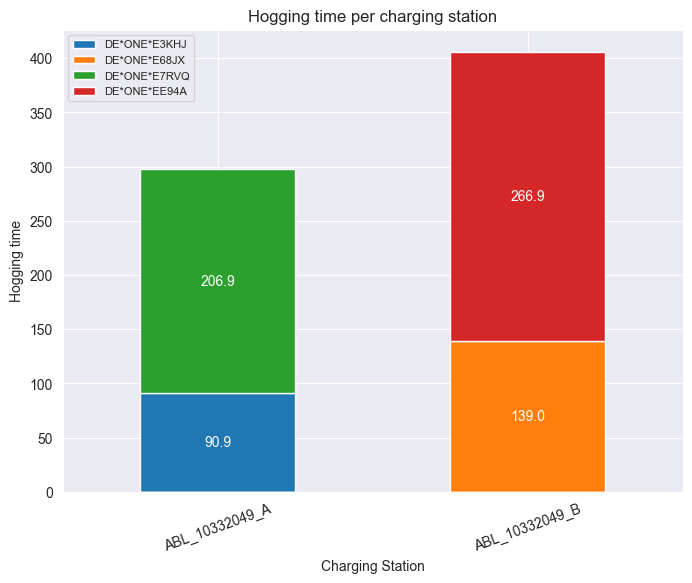

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of hogging time per charging stations using charging points
df = user_data.pivot_table(index='Charging Station', columns='EVSE-ID', values='Hogging time', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Hogging time')
ax.set_xlabel('Charging Station')
ax.set_title('Hogging time per charging station')
ax.legend(loc='upper left', fontsize=8)

# Save figure
plt.savefig('P_images/hogging-time-per-charge-station', bbox_inches='tight')
plt.show()

#### Without outliers

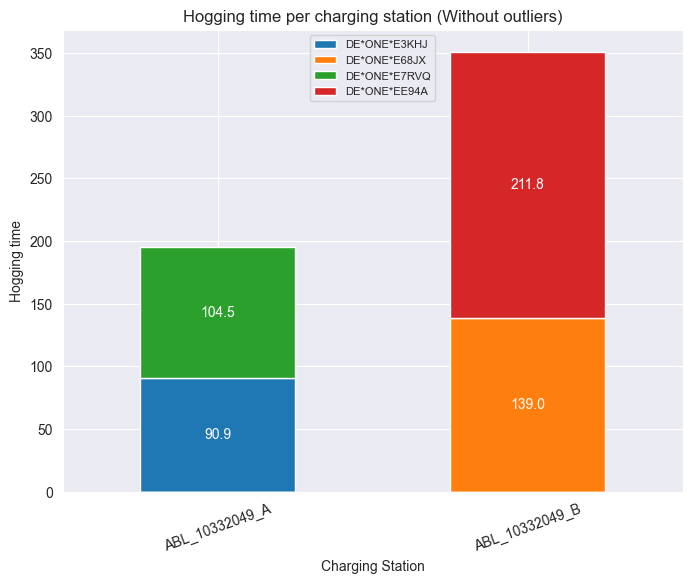

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the stacked bar chart of hogging time per charging stations using charging points
df = user_data_cc_concat.pivot_table(index='Charging Station', columns='EVSE-ID', values='Hogging time', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)

# Label the bars and axes
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Hogging time')
ax.set_xlabel('Charging Station')
ax.set_title('Hogging time per charging station (Without outliers)')
ax.legend(loc='upper center', fontsize=8)

# Save figure
plt.savefig('P_images/hogging-time-per-charge-station-without-outlier', bbox_inches='tight')
plt.show()

### Capacity utilization

In [118]:
# Create a pivot table that contains the total connection time in each month in the charge stations
user_data_blocking_time_sum = pd.pivot_table(user_data, values='Blocking Time', columns=['Plugged_in_month'], index=['Charging Station'], aggfunc="sum")

In [119]:
user_data_ss = user_data.copy()
user_data_ss['Plugged in at (day)'] = user_data_ss['Plugged in at'].dt.day
user_data_ss.groupby('Plugged_in_month')['Plugged in at (day)'].nunique()

Plugged_in_month
September    19
October      27
November     27
December     28
January      29
Name: Plugged in at (day), dtype: int64

In [120]:
# Convert the pivot table to a long format
user_data_blocking_time_month = pd.melt(
    user_data_blocking_time_sum.reset_index(),
    id_vars=['Charging Station'],
    value_vars=['September', 'October', 'November', 'December', 'January'],
    var_name = 'Month',
    value_name = 'Blocking Time'
)

In [121]:
# Create a function that calculates capacity utilization for each month
def capacity_util(df):
    #months = df['Month'].values
    if df['Month'] == 9:
        capacity = (df['Blocking Time'] / 456) * 100
    elif df['Month'] == 10:
        capacity = (df['Blocking Time'] / 648) * 100
    elif df['Month'] == 11:
        capacity = (df['Blocking Time'] / 648) * 100
    elif df['Month'] == 12:
        capacity = (df['Blocking Time'] / 672) * 100
    else:
        capacity = (df['Blocking Time'] / 696) * 100
    return capacity

In [122]:
# Create the capacity utilization column
user_data_blocking_time_month['Capacity utilization'] = user_data_blocking_time_month.apply(capacity_util, axis=1)

In [123]:
# Convert the months to a categorical variable in order to sort it
user_data_blocking_time_month['Month'] = pd.Categorical(
    user_data_blocking_time_month['Month'],
    categories=['September', 'October', 'November', 'December', 'January']
)

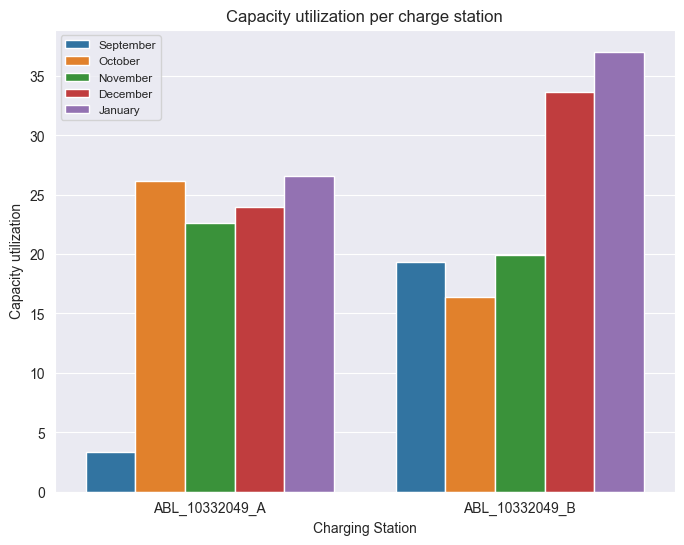

In [124]:
# Create a barplot of the capacity utilization of each month in each charge station
plt.figure(figsize=(8,6))
sns.barplot(
    data=user_data_blocking_time_month.sort_values('Capacity utilization'),
    x='Charging Station',
    y='Capacity utilization',
    hue='Month'
)
plt.title('Capacity utilization per charge station')
#plt.xticks(rotation=15)
#plt.legend([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])
plt.legend(fontsize=8.5)

# Save figure
plt.savefig('P_images/capacity-utilization-per-charge-station')
plt.show()

#### Without outliers

In [126]:
# Create a pivot table that contains the total connection time in each month in the charge stations
user_data_cc_concat_blocking_time_sum = pd.pivot_table(user_data_cc_concat, values='Blocking Time', columns=['Plugged_in_month'], index=['Charging Station'], aggfunc="sum")

In [127]:
# Convert the pivot table to a long format
user_data_cc_concat_blocking_time_month = pd.melt(
    user_data_cc_concat_blocking_time_sum.reset_index(),
    id_vars=['Charging Station'],
    value_vars=['September', 'October', 'November', 'December', 'January'],
    var_name = 'Month',
    value_name = 'Blocking Time'
)

In [128]:
# Create the capacity utilization column
user_data_cc_concat_blocking_time_month['Capacity utilization'] = user_data_cc_concat_blocking_time_month.apply(capacity_util, axis=1)

In [129]:
# Convert the months to a categorical variable in order to sort it
user_data_cc_concat_blocking_time_month['Month'] = pd.Categorical(
    user_data_cc_concat_blocking_time_month['Month'],
    categories=['September', 'October', 'November', 'December', 'January']
)

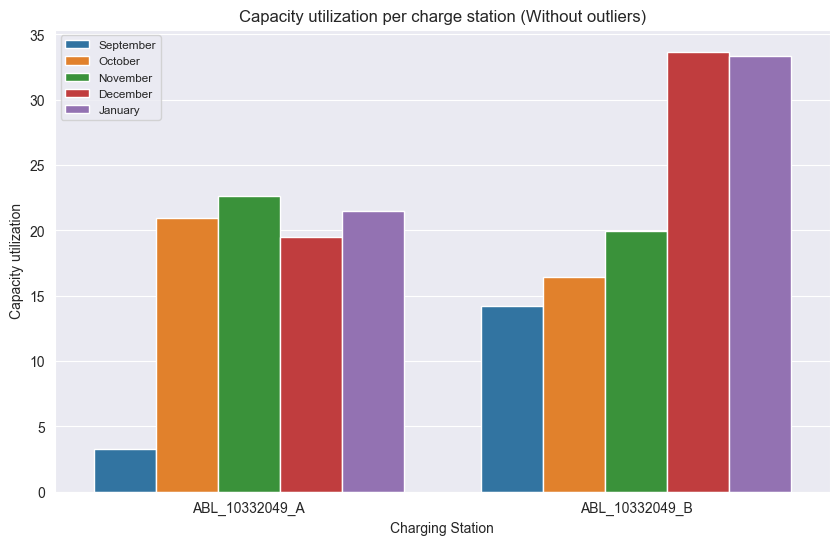

In [130]:
# Create a barplot of the capacity utilization of each month in each charge station
plt.figure(figsize=(10,6))
sns.barplot(
    data=user_data_cc_concat_blocking_time_month.sort_values('Capacity utilization'),
    x='Charging Station',
    y='Capacity utilization',
    hue='Month'
)
plt.title('Capacity utilization per charge station (Without outliers)')
#plt.xticks(rotation=15)
#plt.legend([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])
plt.legend(fontsize=8.5)

# Save figure
plt.savefig('P_images/capacity-utilization-per-charge-station-without-outlier')
plt.show()

In [131]:
user_data_blocking_time_month.groupby('Charging Station')['Capacity utilization'].mean()

Charging Station
ABL_10332049_A    20.515876
ABL_10332049_B    25.286087
Name: Capacity utilization, dtype: float64

In [132]:
user_data_cc_concat_blocking_time_month.groupby('Charging Station')['Capacity utilization'].mean()

Charging Station
ABL_10332049_A    17.572253
ABL_10332049_B    23.523655
Name: Capacity utilization, dtype: float64

### Daytime and nighttime consumption

In [133]:
# Split into daytime and nighttime consumption based on month
user_data_cc_daytime_consumption = user_data_cc_daytime.groupby('Plugged_in_month')['Consumption(kWh)'].sum().reset_index()
user_data_cc_nighttime_consumption = user_data_cc_nighttime.groupby('Plugged_in_month')['Consumption(kWh)'].sum().reset_index()

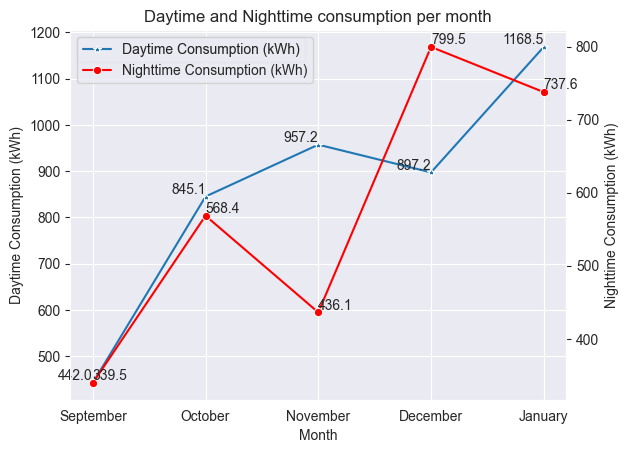

In [134]:
fig, ax = plt.subplots()

sns.lineplot(
    data=user_data_cc_daytime,
    x='Plugged_in_month',
    y='Consumption(kWh)',
    ax=ax,
    estimator='sum',
    ci=None,
    label='Daytime Consumption (kWh)',
    marker='*'
)
#ax.tick_params(axis='y', labelcolor='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Daytime Consumption (kWh)')
#ax.legend(loc='upper center')
for i, (x_val, y_val) in enumerate(zip(user_data_cc_daytime_consumption['Plugged_in_month'], user_data_cc_daytime_consumption['Consumption(kWh)'])):
    plt.text(i, y_val, f'{y_val:.1f}', ha='right', va='bottom')


ax2 = ax.twinx()
ax2.grid(False)

sns.lineplot(
    data=user_data_cc_nighttime,
    x='Plugged_in_month',
    y='Consumption(kWh)',
    ax=ax2,
    estimator='sum',
    ci=None,
    color='red',
    label='Nighttime Consumption (kWh)',
    marker='o'
)
for i, (x_val, y_val) in enumerate(zip(user_data_cc_nighttime_consumption['Plugged_in_month'], user_data_cc_nighttime_consumption['Consumption(kWh)'])):
    plt.text(i, y_val, f'{y_val:.1f}', ha='left', va='bottom')

#plt.xticks([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])
#ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('Nighttime Consumption (kWh)')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)
plt.title('Daytime and Nighttime consumption per month')

# Save figure
plt.savefig('P_images/daytime-nighttime-consumption-per-month')
plt.show()

#### Without outliers

In [135]:
# Extract daytime data
user_data_cc_concat_daytime = user_data_cc_concat.set_index('Plugged in at').between_time('6:00', '18:00').reset_index()

# Extract nighttime data
user_data_cc_concat_nighttime = user_data_cc_concat.set_index('Plugged in at').between_time('18:01', '5:59').reset_index()

In [136]:
# Split into daytime and nighttime consumption based on month
user_data_cc_daytime_consumption = user_data_cc_concat_daytime.groupby('Plugged_in_month')['Consumption(kWh)'].sum().reset_index()
user_data_cc_nighttime_consumption = user_data_cc_concat_nighttime.groupby('Plugged_in_month')['Consumption(kWh)'].sum().reset_index()

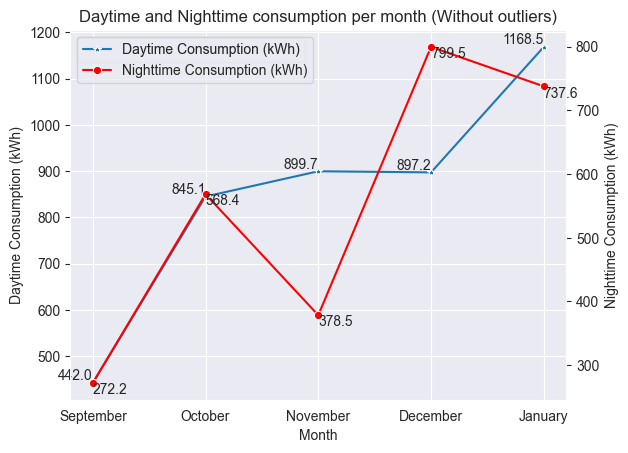

In [137]:
fig, ax = plt.subplots()

sns.lineplot(
    data=user_data_cc_concat_daytime,
    x='Plugged_in_month',
    y='Consumption(kWh)',
    ax=ax,
    estimator='sum',
    ci=None,
    label='Daytime Consumption (kWh)',
    marker='*'
)
#ax.tick_params(axis='y', labelcolor='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Daytime Consumption (kWh)')
for i, (x_val, y_val) in enumerate(zip(user_data_cc_daytime_consumption['Plugged_in_month'], user_data_cc_daytime_consumption['Consumption(kWh)'])):
    plt.text(i, y_val, f'{y_val:.1f}', ha='right', va='bottom')


ax2 = ax.twinx()
ax2.grid(False)

sns.lineplot(
    data=user_data_cc_concat_nighttime,
    x='Plugged_in_month',
    y='Consumption(kWh)',
    ax=ax2,
    estimator='sum',
    ci=None,
    color='red',
    label='Nighttime Consumption (kWh)',
    marker='o'
)
for i, (x_val, y_val) in enumerate(zip(user_data_cc_nighttime_consumption['Plugged_in_month'], user_data_cc_nighttime_consumption['Consumption(kWh)'])):
    plt.text(i, y_val, f'{y_val:.1f}', ha='left', va='top')

#plt.xticks([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])
#ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('Nighttime Consumption (kWh)')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)
plt.title('Daytime and Nighttime consumption per month (Without outliers)')

# Save figure
plt.savefig('P_images/daytime-nighttime-consumption-per-month-without-outlier')
plt.show()

In [139]:
# Check the consumption per month during daytime and nighttime

#user_data_cc_concat_daytime.groupby('Plugged_in_month')['Verbrauch (kWh)'].sum()
user_data_nighttime.groupby('Plugged_in_month')['Consumption(kWh)'].sum()

Plugged_in_month
September    339.517
October      568.390
November     436.092
December     799.490
January      737.646
Name: Consumption(kWh), dtype: float64

In [138]:
# Check the consumption per month during daytime and nighttime

#user_data_cc_concat_daytime.groupby('Plugged_in_month')['Verbrauch (kWh)'].sum()
user_data_cc_concat_nighttime.groupby('Plugged_in_month')['Consumption(kWh)'].sum()

Plugged_in_month
September    272.175000
October      568.390000
November     378.473857
December     799.490000
January      737.646000
Name: Consumption(kWh), dtype: float64

### Charge sessions per month

In [140]:
# Obtain the total charge sessions in ecah month
monthly_charge_time = user_data.groupby('Plugged_in_month')['Charging Duration'].count().reset_index()

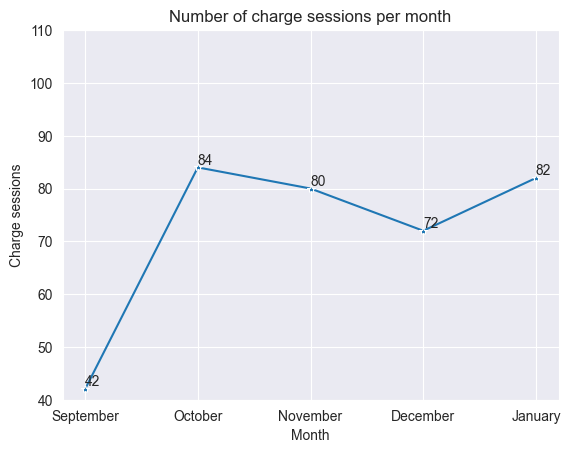

In [141]:
sns.lineplot(
    monthly_charge_time,
    x='Plugged_in_month',
    y='Charging Duration',
    ci=None,
    marker='*'
)
plt.ylim((40, 110))
plt.xlabel('Month')
plt.ylabel('Charge sessions')
plt.title('Number of charge sessions per month')

for i, (x_val, y_val) in enumerate(zip(monthly_charge_time['Plugged_in_month'], monthly_charge_time['Charging Duration'])):
    plt.text(i, y_val, f'{y_val:.0f}', ha='left', va='bottom')

# Save figure
plt.savefig('P_images/charge-sessions-per-month')
plt.show()

### Charge sessions per station

In [142]:
# Obtain the total charge sessions at each charge station
station_charge_time = user_data.groupby('Charging Station')['Charging Duration'].count().reset_index()

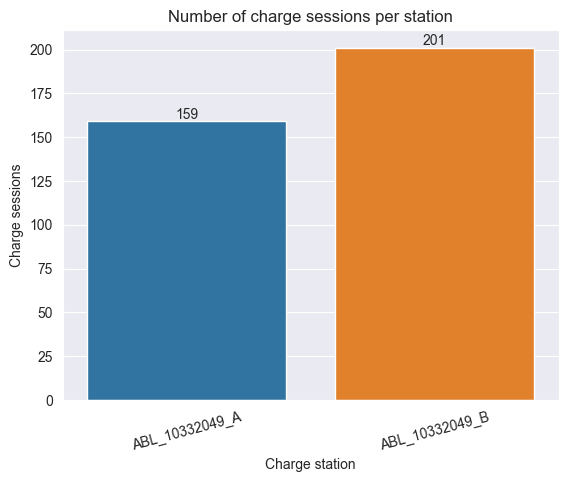

In [143]:
ax = sns.barplot(
    station_charge_time,
    x='Charging Station',
    y='Charging Duration',
    ci=None,
)
plt.xlabel('Charge station')
plt.ylabel('Charge sessions')
plt.xticks(rotation=15)
plt.title('Number of charge sessions per station')
ax.bar_label(ax.containers[0])

# Display the numbers
# for i, (x_val, y_val) in enumerate(zip(station_charge_time['Charging Station'], station_charge_time['Charging Duration'])):
#     plt.text(i, y_val, f'{y_val:.0f}', ha='left', va='bottom')

# Save figure
plt.savefig('P_images/charge-sessions-per-station')
plt.show()

### Consumption per session per month

In [144]:
# Calculate consumption per session
amount_of_consumption = user_data_cc_concat.groupby('Plugged_in_month')['Consumption(kWh)'].sum()
num_of_sessions = user_data_cc_concat.groupby('Plugged_in_month')['Charging Duration'].count()

user_data_cc_concat_kwh_per_session = (amount_of_consumption / num_of_sessions).reset_index()

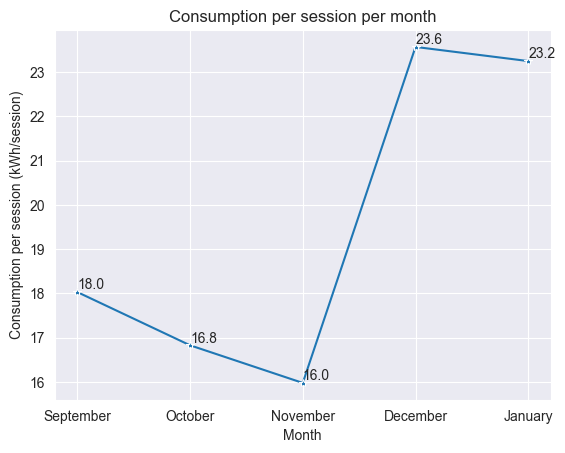

In [145]:
sns.lineplot(
    data=user_data_cc_concat_kwh_per_session,
    x='Plugged_in_month',
    y=0,
    marker='*'
)
plt.xlabel('Month')
plt.ylabel('Consumption per session (kWh/session)')
plt.title('Consumption per session per month')

# Display the numbers
for i, (x_val, y_val) in enumerate(zip(user_data_cc_concat_kwh_per_session['Plugged_in_month'], user_data_cc_concat_kwh_per_session[0])):
    plt.text(i, y_val, f'{y_val:.1f}', ha='left', va='bottom')

# Save figure
plt.savefig('P_images/consumption-per-session-per-month')
plt.show()

In [149]:
# Calculate average energy consumed per session
print(f"The average energy consumed per session is {user_data_cc_concat_kwh_per_session[0].mean()} kWh")

The average energy consumed per session is 19.528897490321334 kWh


### Median energy consumption for each day in each month

In [150]:
# Create a pivot table that contains the total median consumption for each day in each month
median_energy = pd.pivot_table(user_data, values='Consumption(kWh)', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="median")
median_energy

Plugged_in_dayname,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
Plugged_in_month,,,,,,,
September,37.3320,16.400,15.273,24.9740,10.8240,10.293,10.1325
October,10.8010,10.641,10.098,17.9760,11.1420,11.114,11.0015
November,13.6890,15.801,13.254,9.9995,12.4265,8.659,12.1325
December,26.1545,13.674,18.171,14.8350,30.9280,12.095,19.6125
January,28.7420,20.344,18.083,15.5040,15.7660,15.443,12.6645


### Mean energy consumption for each day in each month

In [151]:
# Create a pivot table that contains the mean consumption for each day in each month in the corrected data
mean_energy = pd.pivot_table(user_data_cc_concat, values='Consumption(kWh)', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="mean")
mean_energy

Plugged_in_dayname,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
Plugged_in_month,,,,,,,
September,27.372000,16.130500,15.561000,20.169000,17.156000,11.432000,13.108083
October,16.251360,14.696222,13.854000,19.255909,18.340167,16.648312,18.969300
November,18.611600,21.651643,18.009500,16.799000,19.964250,7.625308,15.831692
December,25.417071,23.361600,23.653556,19.140800,29.020750,15.803909,26.065667
January,33.153400,19.643357,21.813727,33.237200,17.718500,18.902000,20.674750


### Median connection time for each day in each month

In [152]:
# Create a pivot table that contains the median connection time for each day in each month
median_connection_time = pd.pivot_table(user_data, values='Blocking Time', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="median")
median_connection_time

Plugged_in_dayname,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
Plugged_in_month,,,,,,,
September,3.543333,12.576944,1.776389,2.491389,3.644722,2.147500,2.616806
October,2.461667,3.313889,2.835000,2.213611,3.342361,1.647083,2.571667
November,3.440556,3.821389,3.011250,3.703889,6.835694,1.652500,2.531250
December,2.873611,3.632222,2.148056,4.291389,3.595556,2.320278,3.083472
January,4.949444,3.062917,2.792778,4.238611,2.739028,3.575000,3.301389


### Mean connection time for each day in each month

In [153]:
# Create a pivot table that contains the mean connection time for each day in each month in the corrected data
mean_connection_time = pd.pivot_table(user_data_cc_concat, values='Blocking Time', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="mean")
mean_connection_time

Plugged_in_dayname,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
Plugged_in_month,,,,,,,
September,3.139015,9.370972,1.910347,2.516759,3.426389,2.085056,2.425162
October,2.965900,3.275340,2.628730,3.762374,3.398148,2.733576,3.264056
November,3.479648,5.516481,3.953056,4.757500,6.909236,3.237350,2.762222
December,3.741984,9.830778,5.760802,6.603889,5.104028,3.955758,4.989756
January,5.642926,4.785069,3.602576,7.823500,3.174352,5.480429,3.597042


### Average connection and charge time per month

In [154]:
# Create a pivot table that contains the median connection time for each day in each month
avg_connection_time = pd.pivot_table(user_data, values=['Blocking Time', 'Charging Duration'], index=['Plugged_in_month'], aggfunc="mean")
avg_connection_time

,Blocking Time,Charging Duration
Plugged_in_month,,
September,3.745787,2.227652
October,3.526604,2.290807
November,3.706479,2.476385
December,5.572735,2.610313
January,5.397503,2.660528


#### Without outliers

In [155]:
# Create a pivot table that contains the median connection time for each day in each month in the corrected data
avg_connection_time = pd.pivot_table(user_data_cc_concat, values=['Blocking Time', 'Charging Duration'], index=['Plugged_in_month'], aggfunc="mean")
avg_connection_time

,Blocking Time,Charging Duration
Plugged_in_month,,
September,2.968184,2.130718
October,3.097374,2.290807
November,3.706479,2.476385
December,5.140165,2.610313
January,4.654297,2.660528


## PREDICTIVE ANALYSIS FOR USERS

In [156]:
user_data_copy = user_data.copy()

In [157]:
user_data_copy.set_index('Unplugged at', inplace=True)

In [158]:
train = user_data_copy[user_data_copy.index <= pd.to_datetime("2023-12-31 23:59:59", format='%Y-%m-%d %H:%M:%S')]
test = user_data_copy[user_data_copy.index >= pd.to_datetime("2024-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S')]

### Consumption

In [159]:
# Extract relevant columns and set 'Plugged in at' as the index
consumption_data_train = train[['Plugged in at', 'Consumption(kWh)']]
consumption_data_train.set_index('Plugged in at', inplace=True)

#ARIMAmodel = ARIMA(y_train, order=(1,1,1))
ARIMAmodel = ARIMA(consumption_data_train, order=(5,1,2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.forecast(len(test))
#res = pd.DataFrame(y_pred, index=X_test.index)

pred_df = pd.DataFrame(y_pred)
pred_df = pred_df.set_index(test.index)

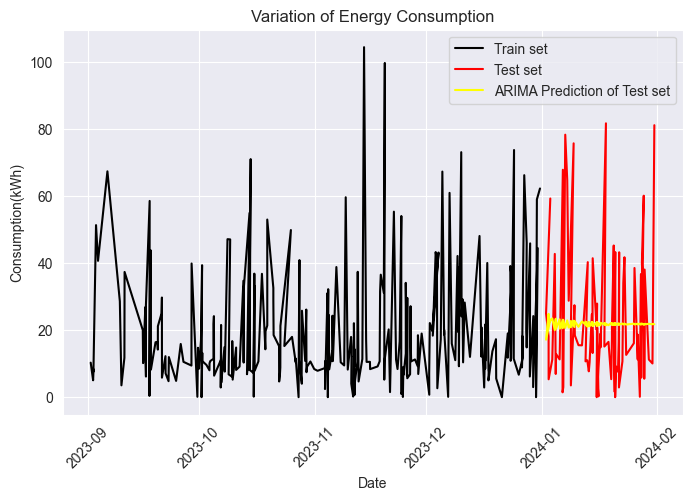

In [160]:
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Consumption(kWh)'], color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(test.index, test['Consumption(kWh)'], color='red', label='Test set')
plt.plot(pred_df, color='Yellow', label='ARIMA Prediction of Test set')
plt.xlabel('Date')
plt.ylabel('Consumption(kWh)')
plt.title('Variation of Energy Consumption')
plt.legend()

# Save figure
plt.savefig('P_images/test-set-consumption')
plt.show()

In [161]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['Consumption(kWh)'], y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 404.8232827650155
Root Mean Squared Error (RMSE): 20.120220743446517


In [162]:
print(f"The actual january consumption is {test['Consumption(kWh)'].sum()} kWh and the predicted january consumption is {pred_df['predicted_mean'].sum()} kWh")

The actual january consumption is 1906.173 kWh and the predicted january consumption is 1788.1413570000843 kWh


### Predict Consumption for the next 12 months

In [163]:
# Forecast future values for each month from Feb to Dec 2024
forecast_steps_per_month = [29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31]  # Days in each month
forecast_values = []

for steps in forecast_steps_per_month:
    forecast_month = ARIMAmodel.get_forecast(steps=steps)
    forecast_values.extend(forecast_month.predicted_mean.tolist())

# Create a DataFrame with timestamp and forecasted values
forecast_dates = pd.date_range(start='2024-02-01', periods=len(forecast_values), freq='D')
forecast_df = pd.DataFrame({'Plugged in at': forecast_dates, 'Predicted Consumption(KWh)': forecast_values})

# Print the forecasted values
print(forecast_df)

    Plugged in at  Predicted Consumption(KWh)
0      2024-02-01                   23.136505
1      2024-02-02                   17.147557
2      2024-02-03                   24.845675
3      2024-02-04                   22.109006
4      2024-02-05                   23.490865
..            ...                         ...
361    2025-01-27                   22.460385
362    2025-01-28                   21.160179
363    2025-01-29                   22.406887
364    2025-01-30                   21.211475
365    2025-01-31                   22.357701

[366 rows x 2 columns]


In [164]:
# Group the forecasted DataFrame by month and sum the values
forecast_df['Month'] = forecast_df['Plugged in at'].dt.to_period('M')
monthly_sum_forecast = forecast_df.groupby('Month')['Predicted Consumption(KWh)'].sum()

# Print the monthly sum forecast
print(monthly_sum_forecast)

Month
2024-02    633.251108
2024-03    676.820284
2024-04    654.462583
2024-05    676.820284
2024-06    654.462583
2024-07    676.820284
2024-08    676.820284
2024-09    654.462583
2024-10    676.820284
2024-11    654.462583
2024-12    676.820284
2025-01    676.820284
Freq: M, Name: Predicted Consumption(KWh), dtype: float64


In [165]:
print(f"The total energy consumption prediction for the next 12 months is {monthly_sum_forecast.sum()} kWh")

The total energy consumption prediction for the next 12 months is 7988.843430043724 kWh


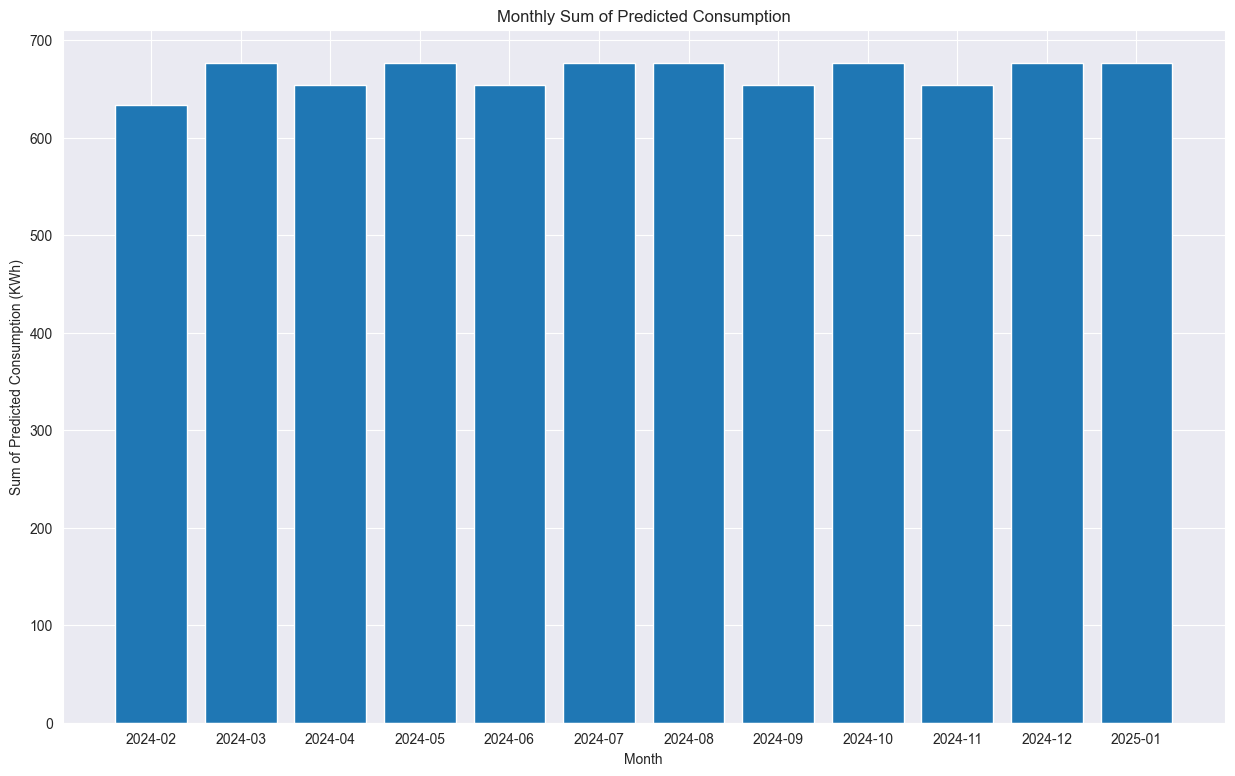

In [166]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
# Plot the monthly sum forecast
plt.bar(monthly_sum_forecast.index.astype(str), monthly_sum_forecast)
plt.xlabel('Month')
plt.ylabel('Sum of Predicted Consumption (KWh)')
plt.title('Monthly Sum of Predicted Consumption')

# Save figure
plt.savefig('P_images/prediction-of-consumption')
plt.show()

### Charge Duration

In [167]:
# Extract relevant columns and set 'Plugged in at' as the index
charge_duration_data_train = train[['Plugged in at', 'Charging Duration']]
charge_duration_data_train.set_index('Plugged in at', inplace=True)

#ARIMAmodel = ARIMA(y_train, order=(1,1,1))
ARIMAmodel = ARIMA(charge_duration_data_train, order=(5,1,2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.forecast(len(test))
#res = pd.DataFrame(y_pred, index=X_test.index)

pred_df = pd.DataFrame(y_pred)
pred_df = pred_df.set_index(test.index)

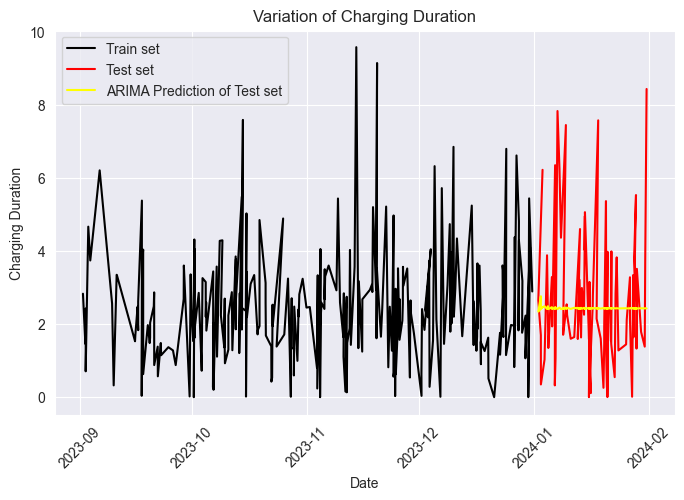

In [168]:
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Charging Duration'], color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(test.index, test['Charging Duration'], color='red', label='Test set')
plt.plot(pred_df, color='Yellow', label='ARIMA Prediction of Test set')
plt.xlabel('Date')
plt.ylabel('Charging Duration')
plt.title('Variation of Charging Duration')
plt.legend()

# Save figure
plt.savefig('P_images/test-set-charge-time')
plt.show()

In [169]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['Charging Duration'], y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse} hours')

Mean Squared Error (MSE): 3.638942212189939
Root Mean Squared Error (RMSE): 1.90760116696073 hours


In [170]:
print(f"The actual january charging duration is {test['Charging Duration'].sum()} hours and the predicted january charging duration is {y_pred.sum()} hours")

The actual january charging duration is 218.16333333333333 hours and the predicted january charging duration is 199.5864708554068 hours


### Predict Charge Duration for the next 12 months

In [171]:
# Forecast future values for each month from Feb to Dec 2024
forecast_steps_per_month = [29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31]  # Days in each month
forecast_values = []

for steps in forecast_steps_per_month:
    forecast_month = ARIMAmodel.get_forecast(steps=steps)
    forecast_values.extend(forecast_month.predicted_mean.tolist())

# Create a DataFrame with timestamp and forecasted values
forecast_dates = pd.date_range(start='2024-02-01', periods=len(forecast_values), freq='D')
forecast_df = pd.DataFrame({'Plugged in at': forecast_dates, 'Predicted Charging Duration': forecast_values})

# Print the forecasted values
print(forecast_df)

    Plugged in at  Predicted Charging Duration
0      2024-02-01                     2.462427
1      2024-02-02                     2.339932
2      2024-02-03                     2.759634
3      2024-02-04                     2.432301
4      2024-02-05                     2.488081
..            ...                          ...
361    2025-01-27                     2.442663
362    2025-01-28                     2.416385
363    2025-01-29                     2.441814
364    2025-01-30                     2.417205
365    2025-01-31                     2.441019

[366 rows x 2 columns]


In [172]:
# Group the forecasted DataFrame by month and sum the values
forecast_df['Month'] = forecast_df['Plugged in at'].dt.to_period('M')
monthly_sum_forecast = forecast_df.groupby('Month')['Predicted Charging Duration'].sum()

# Print the monthly sum forecast
print(monthly_sum_forecast)

Month
2024-02    70.840412
2024-03    75.698637
2024-04    73.257618
2024-05    75.698637
2024-06    73.257618
2024-07    75.698637
2024-08    75.698637
2024-09    73.257618
2024-10    75.698637
2024-11    73.257618
2024-12    75.698637
2025-01    75.698637
Freq: M, Name: Predicted Charging Duration, dtype: float64


In [173]:
print(f"The total charging duration prediction for the next 12 months is {monthly_sum_forecast.sum()} hours")

The total charging duration prediction for the next 12 months is 893.7613404319266 hours


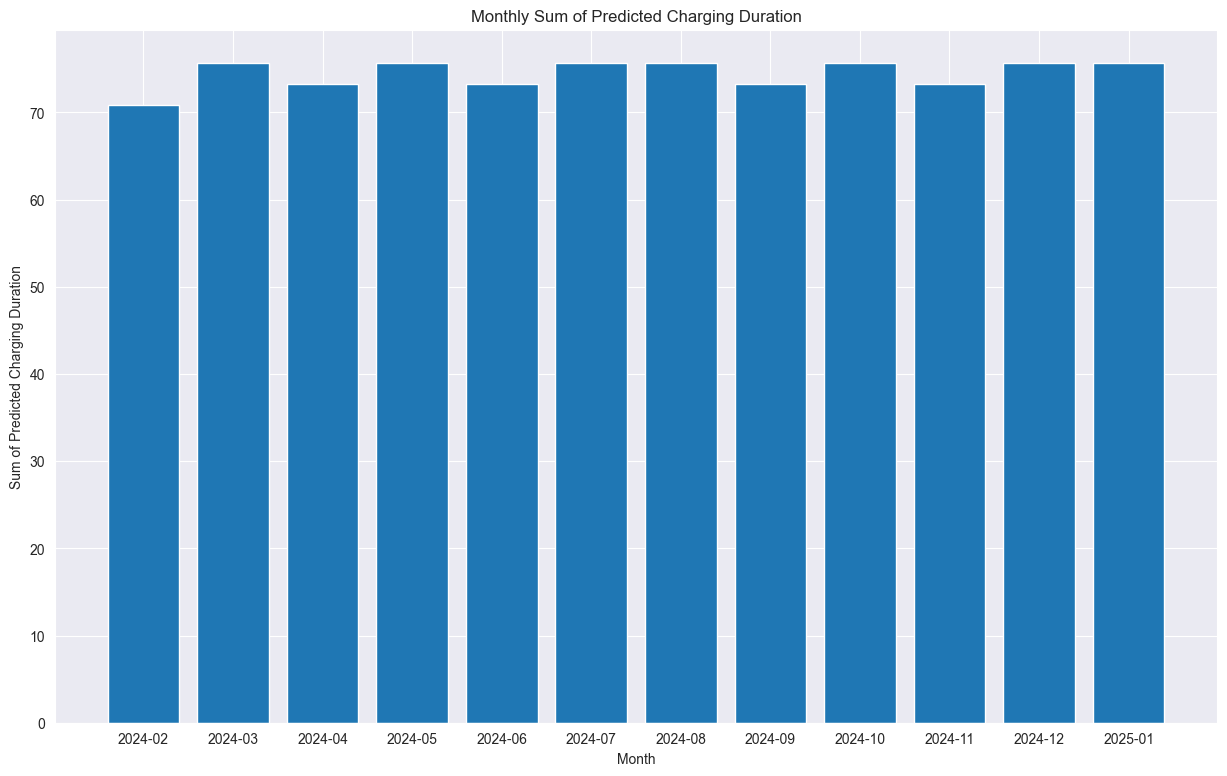

In [174]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
# Plot the monthly sum forecast
plt.bar(monthly_sum_forecast.index.astype(str), monthly_sum_forecast)
plt.xlabel('Month')
plt.ylabel('Sum of Predicted Charging Duration')
plt.title('Monthly Sum of Predicted Charging Duration')

# Save figure
plt.savefig('P_images/prediction-of-charge-time')
plt.show()

## Without outliers

In [175]:
user_data_cc_concat_copy = user_data_cc_concat.copy()

In [176]:
user_data_cc_concat_copy.set_index('Unplugged at', inplace=True)

In [177]:
concat_train = user_data_cc_concat_copy[user_data_cc_concat_copy.index <= pd.to_datetime("2023-12-31 23:59:59", format='%Y-%m-%d %H:%M:%S')]
concat_test = user_data_cc_concat_copy[user_data_cc_concat_copy.index >= pd.to_datetime("2024-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S')]

### Consumption

In [178]:
# Extract relevant columns and set 'Plugged in at' as the index
consumption_data_concat_train = concat_train[['Plugged in at', 'Consumption(kWh)']]
consumption_data_concat_train.set_index('Plugged in at', inplace=True)

# Fit the model to the data
#ARIMAmodel = ARIMA(y_train, order=(1,1,1))
ARIMAmodel = ARIMA(consumption_data_concat_train, order=(5,1,2))
ARIMAmodel = ARIMAmodel.fit()

# Predict the test data
y_pred = ARIMAmodel.forecast(len(concat_test))
#res = pd.DataFrame(y_pred, index=X_test.index)

# Convert test predictions to dataframe
pred_df_concat = pd.DataFrame(ARIMAmodel.forecast(len(concat_test)))
pred_df_concat = pred_df_concat.set_index(concat_test.index)

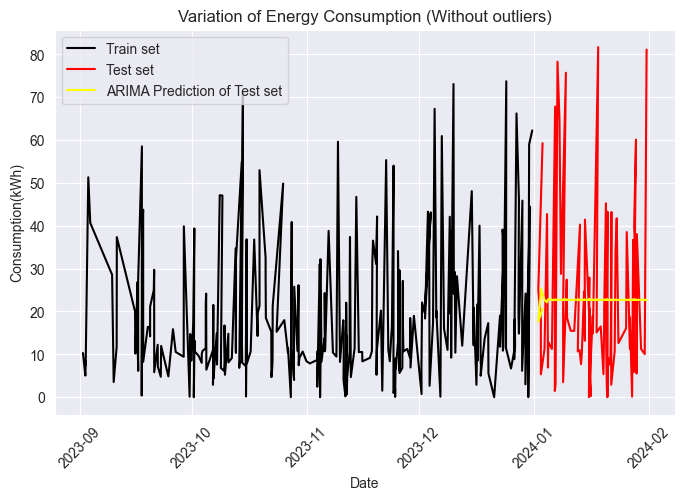

In [179]:
plt.figure(figsize=(8, 5))
plt.plot(concat_train.index, concat_train['Consumption(kWh)'], color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(concat_test.index, concat_test['Consumption(kWh)'], color='red', label='Test set')
plt.plot(pred_df_concat, color='Yellow', label='ARIMA Prediction of Test set')
plt.xlabel('Date')
plt.ylabel('Consumption(kWh)')
plt.title('Variation of Energy Consumption (Without outliers)')
plt.legend()

plt.savefig('P_images/test-set-consumption-without-outliers', bbox_inches='tight')
plt.show()

In [180]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(concat_test['Consumption(kWh)'], y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 405.7117962214564
Root Mean Squared Error (RMSE): 20.142288753303493


In [181]:
print(f"The actual january consumption is {concat_test['Consumption(kWh)'].sum()} kWh and the predicted january consumption is {pred_df_concat['predicted_mean'].sum()} kWh")

The actual january consumption is 1906.173 kWh and the predicted january consumption is 1858.9837509087754 kWh


### Predict Consumption for the next 12 months

In [182]:
# Forecast future values for each month from Feb to Dec 2024
forecast_steps_per_month = [29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31]  # Days in each month
forecast_values = []

for steps in forecast_steps_per_month:
    forecast_month = ARIMAmodel.get_forecast(steps=steps)
    forecast_values.extend(forecast_month.predicted_mean.tolist())

# Create a DataFrame with timestamp and forecasted values
forecast_dates = pd.date_range(start='2024-02-01', periods=len(forecast_values), freq='D')
forecast_df = pd.DataFrame({'Plugged in at': forecast_dates, 'Predicted Consumption(KWh)': forecast_values})

# Print the forecasted values
print(forecast_df)

    Plugged in at  Predicted Consumption(KWh)
0      2024-02-01                   20.610750
1      2024-02-02                   17.638951
2      2024-02-03                   24.347660
3      2024-02-04                   25.363942
4      2024-02-05                   22.694650
..            ...                         ...
361    2025-01-27                   22.763489
362    2025-01-28                   22.657220
363    2025-01-29                   22.763082
364    2025-01-30                   22.657626
365    2025-01-31                   22.762677

[366 rows x 2 columns]


In [183]:
# Group the forecasted DataFrame by month and sum the values
forecast_df['Month'] = forecast_df['Plugged in at'].dt.to_period('M')
monthly_sum_forecast = forecast_df.groupby('Month')['Predicted Consumption(KWh)'].sum()

# Print the monthly sum forecast
print(monthly_sum_forecast)

Month
2024-02    655.388235
2024-03    700.808538
2024-04    678.045861
2024-05    700.808538
2024-06    678.045861
2024-07    700.808538
2024-08    700.808538
2024-09    678.045861
2024-10    700.808538
2024-11    678.045861
2024-12    700.808538
2025-01    700.808538
Freq: M, Name: Predicted Consumption(KWh), dtype: float64


In [184]:
print(f"The total energy consumption prediction for the next 12 months is {monthly_sum_forecast.sum()} kWh")

The total energy consumption prediction for the next 12 months is 8273.2314446979 kWh


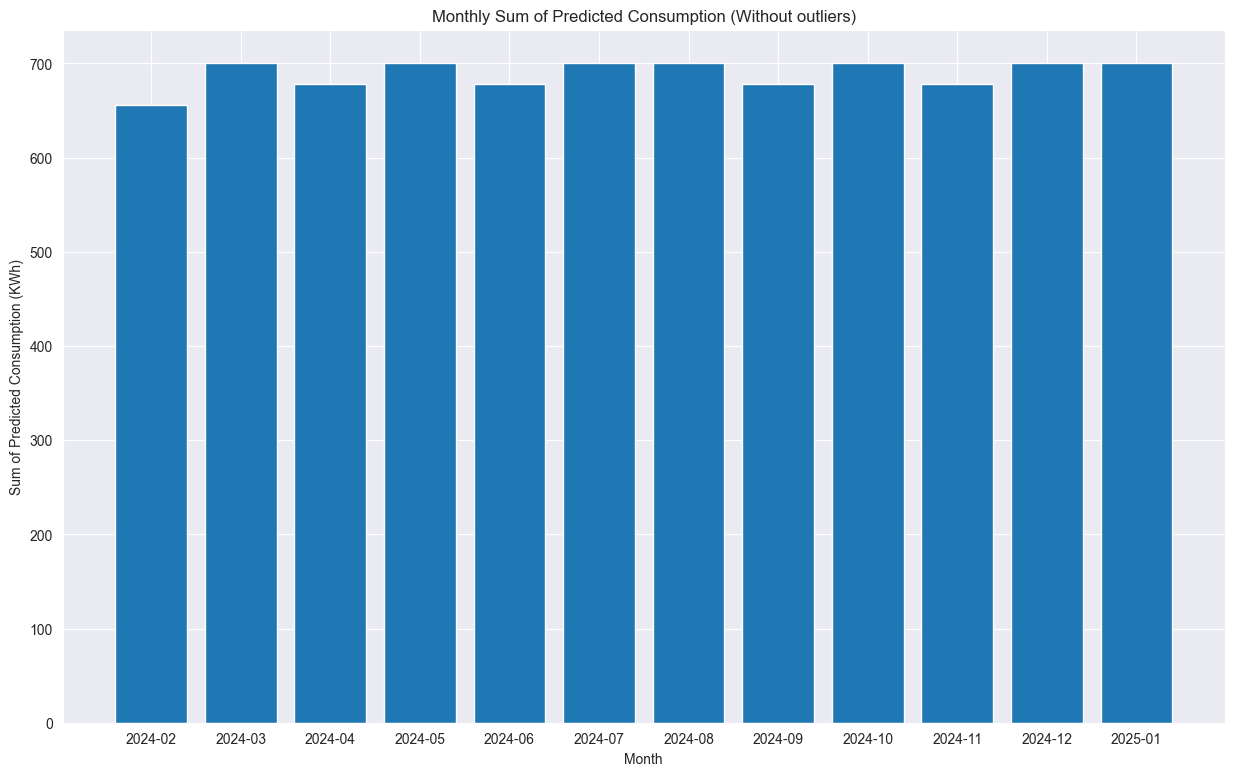

In [185]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
# Plot the monthly sum forecast
plt.bar(monthly_sum_forecast.index.astype(str), monthly_sum_forecast)
plt.xlabel('Month')
plt.ylabel('Sum of Predicted Consumption (KWh)')
plt.title('Monthly Sum of Predicted Consumption (Without outliers)')

plt.savefig('P_images/prediction-of-consumption-without-outliers', bbox_inches='tight')
plt.show()

### Charge Duration

In [186]:
# Extract relevant columns and set 'Plugged in at' as the index
charge_duration_data_concat_train = concat_train[['Plugged in at', 'Charging Duration']]
charge_duration_data_concat_train.set_index('Plugged in at', inplace=True)

#ARIMAmodel = ARIMA(y_train, order=(1,1,1))
ARIMAmodel = ARIMA(charge_duration_data_concat_train, order=(5,1,2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.forecast(len(concat_test))
#res = pd.DataFrame(y_pred, index=X_test.index)

pred_df = pd.DataFrame(y_pred)
pred_df = pred_df.set_index(concat_test.index)

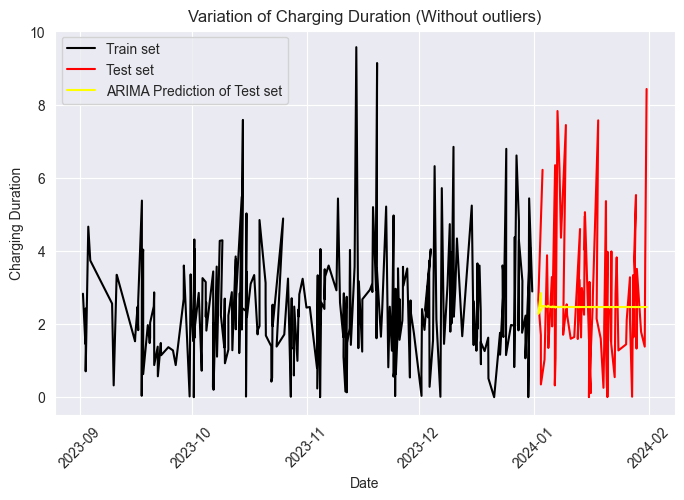

In [187]:
plt.figure(figsize=(8, 5))
plt.plot(concat_train.index, concat_train['Charging Duration'], color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(concat_test.index, concat_test['Charging Duration'], color='red', label='Test set')
plt.plot(pred_df, color='Yellow', label='ARIMA Prediction of Test set')
plt.xlabel('Date')
plt.ylabel('Charging Duration')
plt.title('Variation of Charging Duration (Without outliers)')
plt.legend()

plt.savefig('P_images/test-set-charge-time-without-outliers', bbox_inches='tight')
plt.show()

In [188]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(concat_test['Charging Duration'], y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse} hours')

Mean Squared Error (MSE): 3.6295602994117826
Root Mean Squared Error (RMSE): 1.9051404933525986 hours


In [189]:
print(f"The actual january charging duration is {concat_test['Charging Duration'].sum()} hours and the predicted january charging duration is {y_pred.sum()} hours")

The actual january charging duration is 218.16333333333333 hours and the predicted january charging duration is 202.42849860346018 hours


### Predict Charge Duration for the next 12 months

In [190]:
# Forecast future values for each month from Feb to Dec 2024
forecast_steps_per_month = [29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31]  # Days in each month
forecast_values = []

for steps in forecast_steps_per_month:
    forecast_month = ARIMAmodel.get_forecast(steps=steps)
    forecast_values.extend(forecast_month.predicted_mean.tolist())

# Create a DataFrame with timestamp and forecasted values
forecast_dates = pd.date_range(start='2024-02-01', periods=len(forecast_values), freq='D')
forecast_df = pd.DataFrame({'Plugged in at': forecast_dates, 'Predicted Charging Duration': forecast_values})

# Print the forecasted values
print(forecast_df)

    Plugged in at  Predicted Charging Duration
0      2024-02-01                     2.465962
1      2024-02-02                     2.276019
2      2024-02-03                     2.845967
3      2024-02-04                     2.489738
4      2024-02-05                     2.490218
..            ...                          ...
361    2025-01-27                     2.464071
362    2025-01-28                     2.465450
363    2025-01-29                     2.464334
364    2025-01-30                     2.465234
365    2025-01-31                     2.464508

[366 rows x 2 columns]


In [191]:
# Group the forecasted DataFrame by month and sum the values
forecast_df['Month'] = forecast_df['Plugged in at'].dt.to_period('M')
monthly_sum_forecast = forecast_df.groupby('Month')['Predicted Charging Duration'].sum()

# Print the monthly sum forecast
print(monthly_sum_forecast)

Month
2024-02    71.792230
2024-03    76.721971
2024-04    74.257463
2024-05    76.721971
2024-06    74.257463
2024-07    76.721971
2024-08    76.721971
2024-09    74.257463
2024-10    76.721971
2024-11    74.257463
2024-12    76.721971
2025-01    76.721971
Freq: M, Name: Predicted Charging Duration, dtype: float64


In [192]:
print(f"The total charging duration prediction for the next 12 months is {monthly_sum_forecast.sum()} hours")

The total charging duration prediction for the next 12 months is 905.8758826106647 hours


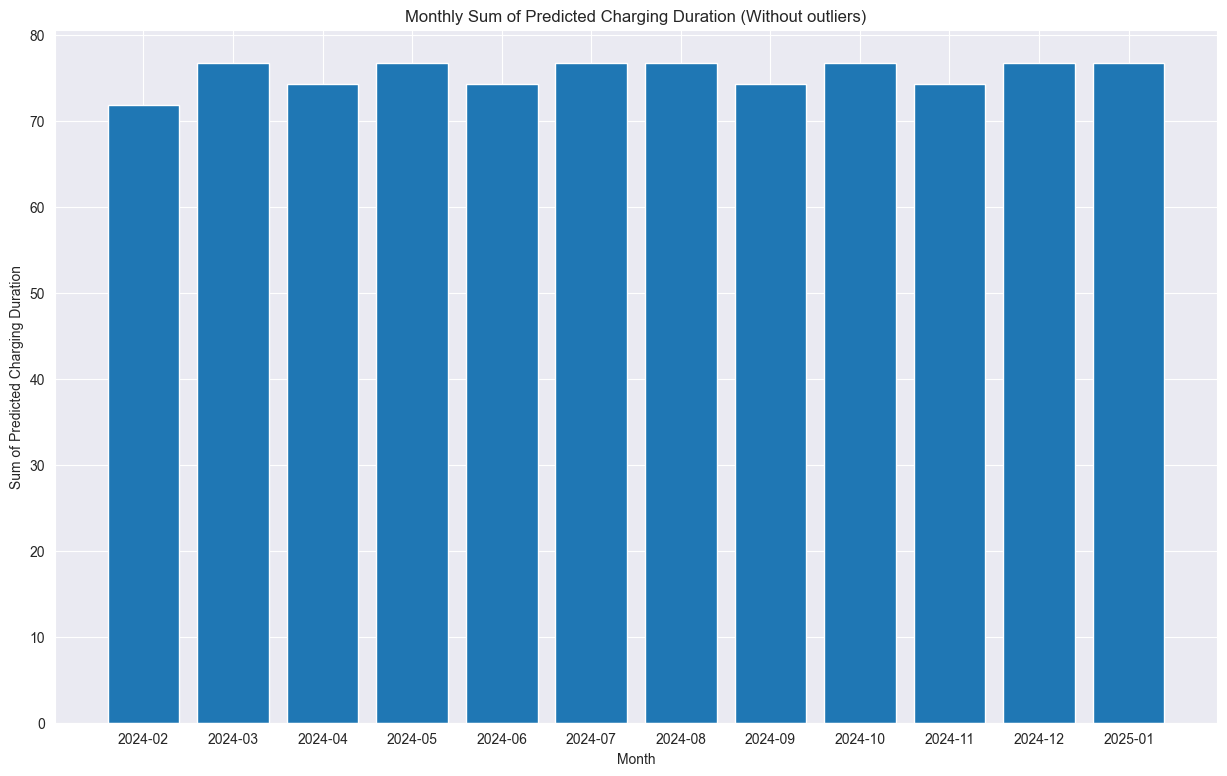

In [193]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
# Plot the monthly sum forecast
plt.bar(monthly_sum_forecast.index.astype(str), monthly_sum_forecast)
plt.xlabel('Month')
plt.ylabel('Sum of Predicted Charging Duration')
plt.title('Monthly Sum of Predicted Charging Duration (Without outliers)')

plt.savefig('P_images/prediction-of-charge-time-without-outliers', bbox_inches='tight')
plt.show()